In [99]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [100]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [101]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [102]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 Pre-processing of the data

### 1.2.1 Pre-processing of the sub-cateogry values

In [103]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in tqdm(catogories):
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)







  0%|                                                                                       | 0/109248 [00:00<?, ?it/s]


  1%|▌                                                                          | 882/109248 [00:00<00:12, 8667.70it/s]


  2%|█▍                                                                        | 2063/109248 [00:00<00:11, 9205.78it/s]


  3%|██▌                                                                       | 3758/109248 [00:00<00:10, 9904.04it/s]


  6%|████▌                                                                    | 6814/109248 [00:00<00:08, 12278.29it/s]


 13%|█████████▏                                                              | 13868/109248 [00:00<00:05, 16191.23it/s]


 15%|███████████                                                             | 16698/109248 [00:00<00:05, 18296.72it/s]


 20%|██████████████▍                                                         | 21976/109248 [00:00<00:03, 22736.61it/s]


 30%|████████████████

In [104]:
from collections import Counter
my_counter = Counter()
for word in tqdm(project_data['clean_categories'].values):
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))




  0%|                                                                                       | 0/109248 [00:00<?, ?it/s]


 22%|███████████████▍                                                       | 23731/109248 [00:00<00:00, 235589.77it/s]


 46%|████████████████████████████████▋                                      | 50253/109248 [00:00<00:00, 243268.84it/s]


 63%|████████████████████████████████████████████▊                          | 68964/109248 [00:00<00:00, 222592.93it/s]


 79%|███████████████████████████████████████████████████████▉               | 86110/109248 [00:00<00:00, 203780.61it/s]


 99%|█████████████████████████████████████████████████████████████████████ | 107692/109248 [00:00<00:00, 206814.65it/s]


100%|██████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 212699.77it/s]

### 1.2.2 preprocessing of `project_subject_subcategories`

In [105]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### 1.2.3 Text preprocessing

In [106]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [107]:
# project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [108]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [109]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [110]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [111]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in project_data['essay'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

In [112]:
# after preprocesing
preprocessed_essays[20000]

'kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism eager beavers always strive work hardest working past limitations materials ones seek students teach title school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore ever felt like ants pants needed groove move meeting kids feel time want able move learn say wobble chairs answer love develop core enhances gross motor turn fine motor skills also want learn games kids not want sit worksheets want learn count jumping playing physical engagement key success number toss color shape mats make happen students forget work fun 6 year old deserves nannan'

In [113]:
project_data['essay'] = preprocessed_essays

<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

In [114]:
# similarly you can preprocess the titles also
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in project_data['project_title'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

In [115]:
preprocessed_titles[20000]

'need move input'

In [116]:
project_data['project_title'] = preprocessed_titles

### 1.4.1 Preprocessing of the teacher_prefix

In [117]:
project_data['teacher_prefix'].fillna("Others",inplace = True)
set(project_data['teacher_prefix'].values)

{'Dr.', 'Mr.', 'Mrs.', 'Ms.', 'Others', 'Teacher'}

### 1.4.2 Preprocessing of the price

In [118]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

###  1.4.3 Preprocessing of the Project_grad

In [119]:
lst = list(project_data['project_grade_category'].values)
preprocessed_grades = []
for l in lst:
    l = l.replace(' ','_')
    preprocessed_grades.append(l)
set(preprocessed_grades)

{'Grades_3-5', 'Grades_6-8', 'Grades_9-12', 'Grades_PreK-2'}

In [120]:
project_data['project_grade_category'] = preprocessed_grades

### 1.4.3 Sentimental Score of pre-processed essay

In [121]:
essays = project_data['essay'].copy()

In [122]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

sent_essays = []
no_essays = []

for essay in tqdm(essays):
    ss = sid.polarity_scores(essay)
    sent_essays.append(ss['compound'])
    no_essays.append(len(essay.split(' ')))




  0%|                                                                                       | 0/109248 [00:00<?, ?it/s]


  0%|                                                                             | 1/109248 [00:00<5:04:17,  5.98it/s]


  0%|                                                                            | 31/109248 [00:00<3:34:49,  8.47it/s]


  0%|                                                                            | 63/109248 [00:00<2:32:03, 11.97it/s]


  0%|                                                                           | 100/109248 [00:00<1:47:53, 16.86it/s]


  0%|                                                                           | 135/109248 [00:00<1:17:07, 23.58it/s]


  0%|                                                                             | 171/109248 [00:00<55:30, 32.75it/s]


  0%|▏                                                                            | 205/109248 [00:00<40:29, 44.89it/s]


  0%|▏               

  5%|███▍                                                                       | 4996/109248 [00:14<04:48, 361.39it/s]


  5%|███▍                                                                       | 5039/109248 [00:14<04:35, 377.83it/s]


  5%|███▍                                                                       | 5078/109248 [00:14<04:44, 366.63it/s]


  5%|███▌                                                                       | 5116/109248 [00:14<04:41, 369.79it/s]


  5%|███▌                                                                       | 5155/109248 [00:14<04:38, 373.73it/s]


  5%|███▌                                                                       | 5193/109248 [00:14<04:37, 374.78it/s]


  5%|███▌                                                                       | 5231/109248 [00:14<04:36, 375.51it/s]


  5%|███▌                                                                       | 5276/109248 [00:15<04:24, 392.35it/s]


  5%|███▋               

  9%|██████▉                                                                   | 10284/109248 [00:28<04:27, 370.49it/s]


  9%|██████▉                                                                   | 10323/109248 [00:28<04:23, 375.30it/s]


  9%|███████                                                                   | 10361/109248 [00:28<04:25, 372.57it/s]


 10%|███████                                                                   | 10399/109248 [00:29<04:28, 367.47it/s]


 10%|███████                                                                   | 10436/109248 [00:29<04:29, 366.37it/s]


 10%|███████                                                                   | 10475/109248 [00:29<04:25, 372.37it/s]


 10%|███████                                                                   | 10513/109248 [00:29<04:29, 366.27it/s]


 10%|███████▏                                                                  | 10550/109248 [00:29<04:55, 333.92it/s]


 10%|███████▏           

 14%|██████████▍                                                               | 15384/109248 [00:43<04:07, 379.63it/s]


 14%|██████████▍                                                               | 15424/109248 [00:43<04:04, 383.57it/s]


 14%|██████████▍                                                               | 15468/109248 [00:43<03:55, 398.12it/s]


 14%|██████████▌                                                               | 15514/109248 [00:44<03:46, 414.05it/s]


 14%|██████████▌                                                               | 15561/109248 [00:44<03:38, 428.57it/s]


 14%|██████████▌                                                               | 15605/109248 [00:44<03:39, 425.97it/s]


 14%|██████████▌                                                               | 15654/109248 [00:44<03:32, 440.09it/s]


 14%|██████████▋                                                               | 15703/109248 [00:44<03:26, 453.09it/s]


 14%|██████████▋        

 18%|█████████████                                                             | 19193/109248 [00:59<04:36, 325.24it/s]


 18%|█████████████                                                             | 19232/109248 [00:59<04:24, 340.74it/s]


 18%|█████████████                                                             | 19268/109248 [00:59<04:27, 336.86it/s]


 18%|█████████████                                                             | 19305/109248 [00:59<04:20, 345.80it/s]


 18%|█████████████                                                             | 19342/109248 [01:00<04:16, 349.96it/s]


 18%|█████████████▏                                                            | 19378/109248 [01:00<04:45, 315.28it/s]


 18%|█████████████▏                                                            | 19411/109248 [01:00<05:01, 298.18it/s]


 18%|█████████████▏                                                            | 19448/109248 [01:00<04:44, 316.00it/s]


 18%|█████████████▏     

 22%|████████████████▎                                                         | 24048/109248 [01:15<04:37, 307.14it/s]


 22%|████████████████▎                                                         | 24095/109248 [01:15<04:09, 341.39it/s]


 22%|████████████████▎                                                         | 24131/109248 [01:15<04:08, 343.11it/s]


 22%|████████████████▎                                                         | 24167/109248 [01:15<04:24, 322.17it/s]


 22%|████████████████▍                                                         | 24201/109248 [01:15<04:26, 319.29it/s]


 22%|████████████████▍                                                         | 24246/109248 [01:15<04:04, 347.56it/s]


 22%|████████████████▍                                                         | 24294/109248 [01:15<03:44, 378.24it/s]


 22%|████████████████▍                                                         | 24336/109248 [01:16<03:38, 388.04it/s]


 22%|████████████████▌  

 27%|███████████████████▊                                                      | 29230/109248 [01:29<03:53, 343.29it/s]


 27%|███████████████████▊                                                      | 29266/109248 [01:30<03:52, 343.44it/s]


 27%|███████████████████▊                                                      | 29302/109248 [01:30<04:06, 324.98it/s]


 27%|███████████████████▊                                                      | 29336/109248 [01:30<04:10, 319.41it/s]


 27%|███████████████████▉                                                      | 29385/109248 [01:30<03:45, 354.53it/s]


 27%|███████████████████▉                                                      | 29423/109248 [01:30<03:58, 335.34it/s]


 27%|███████████████████▉                                                      | 29458/109248 [01:30<04:16, 310.96it/s]


 27%|███████████████████▉                                                      | 29509/109248 [01:30<03:47, 350.92it/s]


 27%|███████████████████

 32%|███████████████████████▋                                                  | 35062/109248 [01:44<02:54, 423.99it/s]


 32%|███████████████████████▊                                                  | 35112/109248 [01:44<02:47, 443.35it/s]


 32%|███████████████████████▊                                                  | 35160/109248 [01:44<02:44, 451.58it/s]


 32%|███████████████████████▊                                                  | 35211/109248 [01:44<02:39, 465.39it/s]


 32%|███████████████████████▉                                                  | 35258/109248 [01:45<02:40, 461.69it/s]


 32%|███████████████████████▉                                                  | 35305/109248 [01:45<02:46, 444.74it/s]


 32%|███████████████████████▉                                                  | 35353/109248 [01:45<02:43, 452.59it/s]


 32%|███████████████████████▉                                                  | 35399/109248 [01:45<02:42, 453.76it/s]


 32%|███████████████████

 38%|███████████████████████████▉                                              | 41321/109248 [01:58<03:09, 357.91it/s]


 38%|████████████████████████████                                              | 41361/109248 [01:58<03:04, 368.83it/s]


 38%|████████████████████████████                                              | 41399/109248 [01:58<03:02, 371.35it/s]


 38%|████████████████████████████                                              | 41441/109248 [01:58<02:56, 383.95it/s]


 38%|████████████████████████████                                              | 41482/109248 [01:59<02:54, 389.44it/s]


 38%|████████████████████████████▏                                             | 41522/109248 [01:59<02:52, 391.75it/s]


 38%|████████████████████████████▏                                             | 41562/109248 [01:59<02:56, 383.15it/s]


 38%|████████████████████████████▏                                             | 41601/109248 [01:59<03:00, 374.41it/s]


 38%|███████████████████

 43%|███████████████████████████████▌                                          | 46592/109248 [02:12<03:03, 340.67it/s]


 43%|███████████████████████████████▌                                          | 46627/109248 [02:12<03:09, 331.02it/s]


 43%|███████████████████████████████▌                                          | 46665/109248 [02:13<03:03, 341.80it/s]


 43%|███████████████████████████████▋                                          | 46700/109248 [02:13<03:03, 341.48it/s]


 43%|███████████████████████████████▋                                          | 46744/109248 [02:13<02:51, 364.50it/s]


 43%|███████████████████████████████▋                                          | 46782/109248 [02:13<02:50, 367.20it/s]


 43%|███████████████████████████████▋                                          | 46827/109248 [02:13<02:42, 382.98it/s]


 43%|███████████████████████████████▋                                          | 46869/109248 [02:13<02:38, 392.54it/s]


 43%|███████████████████

 47%|██████████████████████████████████▉                                       | 51574/109248 [02:27<02:42, 355.98it/s]


 47%|██████████████████████████████████▉                                       | 51610/109248 [02:27<02:42, 354.26it/s]


 47%|██████████████████████████████████▉                                       | 51646/109248 [02:27<02:44, 351.09it/s]


 47%|███████████████████████████████████                                       | 51682/109248 [02:27<02:44, 350.89it/s]


 47%|███████████████████████████████████                                       | 51724/109248 [02:27<02:36, 367.44it/s]


 47%|███████████████████████████████████                                       | 51761/109248 [02:27<02:36, 367.40it/s]


 47%|███████████████████████████████████                                       | 51799/109248 [02:27<02:35, 370.26it/s]


 47%|███████████████████████████████████                                       | 51837/109248 [02:28<02:35, 370.20it/s]


 47%|███████████████████

 52%|██████████████████████████████████████▎                                   | 56522/109248 [02:41<02:36, 336.54it/s]


 52%|██████████████████████████████████████▎                                   | 56559/109248 [02:41<02:33, 344.23it/s]


 52%|██████████████████████████████████████▎                                   | 56594/109248 [02:42<02:46, 315.44it/s]


 52%|██████████████████████████████████████▎                                   | 56627/109248 [02:42<02:45, 318.07it/s]


 52%|██████████████████████████████████████▍                                   | 56660/109248 [02:42<02:46, 315.37it/s]


 52%|██████████████████████████████████████▍                                   | 56693/109248 [02:42<02:45, 318.02it/s]


 52%|██████████████████████████████████████▍                                   | 56728/109248 [02:42<02:40, 326.32it/s]


 52%|██████████████████████████████████████▍                                   | 56761/109248 [02:42<02:43, 320.07it/s]


 52%|███████████████████

 55%|█████████████████████████████████████████                                 | 60530/109248 [02:56<02:55, 277.41it/s]


 55%|█████████████████████████████████████████                                 | 60558/109248 [02:56<03:00, 269.58it/s]


 55%|█████████████████████████████████████████                                 | 60589/109248 [02:56<02:55, 277.01it/s]


 55%|█████████████████████████████████████████                                 | 60622/109248 [02:56<02:47, 290.47it/s]


 56%|█████████████████████████████████████████                                 | 60655/109248 [02:56<02:43, 297.45it/s]


 56%|█████████████████████████████████████████                                 | 60691/109248 [02:56<02:35, 312.39it/s]


 56%|█████████████████████████████████████████▏                                | 60723/109248 [02:57<02:42, 299.04it/s]


 56%|█████████████████████████████████████████▏                                | 60756/109248 [02:57<02:38, 306.22it/s]


 56%|███████████████████

 60%|████████████████████████████████████████████▏                             | 65182/109248 [03:10<02:09, 340.41it/s]


 60%|████████████████████████████████████████████▏                             | 65218/109248 [03:10<02:07, 345.33it/s]


 60%|████████████████████████████████████████████▏                             | 65253/109248 [03:10<02:12, 333.16it/s]


 60%|████████████████████████████████████████████▏                             | 65294/109248 [03:11<02:04, 352.34it/s]


 60%|████████████████████████████████████████████▎                             | 65330/109248 [03:11<02:08, 341.75it/s]


 60%|████████████████████████████████████████████▎                             | 65365/109248 [03:11<02:11, 334.63it/s]


 60%|████████████████████████████████████████████▎                             | 65402/109248 [03:11<02:07, 343.77it/s]


 60%|████████████████████████████████████████████▎                             | 65438/109248 [03:11<02:05, 347.75it/s]


 60%|███████████████████

 64%|███████████████████████████████████████████████▌                          | 70246/109248 [03:25<02:03, 315.80it/s]


 64%|███████████████████████████████████████████████▌                          | 70286/109248 [03:25<01:56, 335.62it/s]


 64%|███████████████████████████████████████████████▋                          | 70321/109248 [03:25<01:58, 329.56it/s]


 64%|███████████████████████████████████████████████▋                          | 70355/109248 [03:25<01:57, 331.92it/s]


 64%|███████████████████████████████████████████████▋                          | 70392/109248 [03:25<01:53, 341.76it/s]


 64%|███████████████████████████████████████████████▋                          | 70431/109248 [03:25<01:49, 354.26it/s]


 65%|███████████████████████████████████████████████▋                          | 70472/109248 [03:25<01:45, 367.61it/s]


 65%|███████████████████████████████████████████████▊                          | 70513/109248 [03:25<01:42, 378.58it/s]


 65%|███████████████████

 69%|██████████████████████████████████████████████████▉                       | 75219/109248 [03:39<02:13, 254.58it/s]


 69%|██████████████████████████████████████████████████▉                       | 75259/109248 [03:39<01:59, 284.67it/s]


 69%|███████████████████████████████████████████████████                       | 75307/109248 [03:39<01:45, 323.12it/s]


 69%|███████████████████████████████████████████████████                       | 75343/109248 [03:39<01:44, 323.77it/s]


 69%|███████████████████████████████████████████████████                       | 75380/109248 [03:39<01:41, 332.10it/s]


 69%|███████████████████████████████████████████████████                       | 75421/109248 [03:40<01:36, 350.59it/s]


 69%|███████████████████████████████████████████████████                       | 75462/109248 [03:40<01:32, 364.83it/s]


 69%|███████████████████████████████████████████████████▏                      | 75507/109248 [03:40<01:27, 384.09it/s]


 69%|███████████████████

 73%|██████████████████████████████████████████████████████▍                   | 80285/109248 [03:54<01:35, 302.45it/s]


 74%|██████████████████████████████████████████████████████▍                   | 80321/109248 [03:54<01:31, 315.41it/s]


 74%|██████████████████████████████████████████████████████▍                   | 80359/109248 [03:54<01:27, 330.86it/s]


 74%|██████████████████████████████████████████████████████▍                   | 80399/109248 [03:54<01:23, 344.70it/s]


 74%|██████████████████████████████████████████████████████▍                   | 80441/109248 [03:54<01:19, 362.62it/s]


 74%|██████████████████████████████████████████████████████▌                   | 80478/109248 [03:54<01:25, 338.18it/s]


 74%|██████████████████████████████████████████████████████▌                   | 80513/109248 [03:55<01:26, 334.10it/s]


 74%|██████████████████████████████████████████████████████▌                   | 80549/109248 [03:55<01:24, 340.76it/s]


 74%|███████████████████

 79%|██████████████████████████████████████████████████████████▏               | 85872/109248 [04:08<01:08, 338.97it/s]


 79%|██████████████████████████████████████████████████████████▏               | 85909/109248 [04:09<01:07, 345.07it/s]


 79%|██████████████████████████████████████████████████████████▏               | 85945/109248 [04:09<01:08, 342.68it/s]


 79%|██████████████████████████████████████████████████████████▏               | 85980/109248 [04:09<01:10, 327.74it/s]


 79%|██████████████████████████████████████████████████████████▎               | 86014/109248 [04:09<01:13, 314.17it/s]


 79%|██████████████████████████████████████████████████████████▎               | 86046/109248 [04:09<01:15, 307.07it/s]


 79%|██████████████████████████████████████████████████████████▎               | 86087/109248 [04:09<01:10, 330.69it/s]


 79%|██████████████████████████████████████████████████████████▎               | 86121/109248 [04:09<01:13, 316.06it/s]


 79%|███████████████████

 83%|█████████████████████████████████████████████████████████████             | 90218/109248 [04:23<01:11, 267.26it/s]


 83%|█████████████████████████████████████████████████████████████▏            | 90246/109248 [04:23<01:11, 265.76it/s]


 83%|█████████████████████████████████████████████████████████████▏            | 90273/109248 [04:23<01:11, 266.47it/s]


 83%|█████████████████████████████████████████████████████████████▏            | 90300/109248 [04:23<01:11, 266.15it/s]


 83%|█████████████████████████████████████████████████████████████▏            | 90330/109248 [04:24<01:09, 273.42it/s]


 83%|█████████████████████████████████████████████████████████████▏            | 90358/109248 [04:24<01:10, 266.93it/s]


 83%|█████████████████████████████████████████████████████████████▏            | 90398/109248 [04:24<01:03, 296.05it/s]


 83%|█████████████████████████████████████████████████████████████▎            | 90433/109248 [04:24<01:00, 309.80it/s]


 83%|███████████████████

 87%|████████████████████████████████████████████████████████████████          | 94579/109248 [04:38<00:51, 284.84it/s]


 87%|████████████████████████████████████████████████████████████████          | 94613/109248 [04:38<00:48, 298.83it/s]


 87%|████████████████████████████████████████████████████████████████          | 94644/109248 [04:38<00:48, 299.71it/s]


 87%|████████████████████████████████████████████████████████████████▏         | 94675/109248 [04:38<00:51, 281.56it/s]


 87%|████████████████████████████████████████████████████████████████▏         | 94704/109248 [04:38<00:52, 275.38it/s]


 87%|████████████████████████████████████████████████████████████████▏         | 94738/109248 [04:38<00:49, 291.48it/s]


 87%|████████████████████████████████████████████████████████████████▏         | 94770/109248 [04:38<00:48, 298.85it/s]


 87%|████████████████████████████████████████████████████████████████▏         | 94802/109248 [04:38<00:47, 303.42it/s]


 87%|███████████████████

 90%|██████████████████████████████████████████████████████████████████▊       | 98659/109248 [04:52<00:52, 200.73it/s]


 90%|██████████████████████████████████████████████████████████████████▊       | 98685/109248 [04:52<00:50, 210.39it/s]


 90%|██████████████████████████████████████████████████████████████████▊       | 98707/109248 [04:52<00:49, 211.51it/s]


 90%|██████████████████████████████████████████████████████████████████▊       | 98729/109248 [04:53<00:51, 203.48it/s]


 90%|██████████████████████████████████████████████████████████████████▉       | 98752/109248 [04:53<00:50, 209.78it/s]


 90%|██████████████████████████████████████████████████████████████████▉       | 98774/109248 [04:53<00:49, 212.29it/s]


 90%|██████████████████████████████████████████████████████████████████▉       | 98796/109248 [04:53<00:48, 214.09it/s]


 90%|██████████████████████████████████████████████████████████████████▉       | 98818/109248 [04:53<00:48, 214.11it/s]


 90%|███████████████████

 94%|████████████████████████████████████████████████████████████████████▎    | 102193/109248 [05:07<00:23, 295.76it/s]


 94%|████████████████████████████████████████████████████████████████████▎    | 102225/109248 [05:07<00:23, 302.04it/s]


 94%|████████████████████████████████████████████████████████████████████▎    | 102261/109248 [05:07<00:22, 315.10it/s]


 94%|████████████████████████████████████████████████████████████████████▎    | 102297/109248 [05:07<00:21, 325.78it/s]


 94%|████████████████████████████████████████████████████████████████████▍    | 102330/109248 [05:07<00:21, 324.41it/s]


 94%|████████████████████████████████████████████████████████████████████▍    | 102363/109248 [05:07<00:21, 321.60it/s]


 94%|████████████████████████████████████████████████████████████████████▍    | 102396/109248 [05:07<00:21, 318.71it/s]


 94%|████████████████████████████████████████████████████████████████████▍    | 102437/109248 [05:08<00:20, 340.05it/s]


 94%|███████████████████

 98%|███████████████████████████████████████████████████████████████████████▎ | 106814/109248 [05:21<00:07, 309.56it/s]


 98%|███████████████████████████████████████████████████████████████████████▍ | 106846/109248 [05:21<00:07, 302.25it/s]


 98%|███████████████████████████████████████████████████████████████████████▍ | 106877/109248 [05:21<00:07, 296.92it/s]


 98%|███████████████████████████████████████████████████████████████████████▍ | 106907/109248 [05:21<00:08, 287.81it/s]


 98%|███████████████████████████████████████████████████████████████████████▍ | 106943/109248 [05:22<00:07, 304.88it/s]


 98%|███████████████████████████████████████████████████████████████████████▍ | 106976/109248 [05:22<00:07, 311.33it/s]


 98%|███████████████████████████████████████████████████████████████████████▌ | 107008/109248 [05:22<00:07, 309.57it/s]


 98%|███████████████████████████████████████████████████████████████████████▌ | 107044/109248 [05:22<00:06, 322.56it/s]


 98%|███████████████████

### 1.4.4 Number of words in the title

In [123]:
no_title = []
for title in tqdm(project_data['project_title']):
    no_title.append(len(title.split(' ')))
len(no_title)




  0%|                                                                                       | 0/109248 [00:00<?, ?it/s]


 53%|█████████████████████████████████████▍                                 | 57682/109248 [00:00<00:00, 572638.70it/s]


100%|██████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 601869.27it/s]

109248

In [124]:
project_data['words_essay'] = no_essays
project_data['words_title'] = no_title
project_data['sentiment'] = sent_essays
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'words_essay', 'words_title', 'sentiment'],
      dtype='object')

## 1.5 Preparing data for models

In [125]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'words_essay', 'words_title', 'sentiment'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

<h1>2. Logistic Regression </h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [126]:
y = project_data["project_is_approved"]
X = project_data.drop("project_is_approved",axis = 1)
X.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'quantity', 'words_essay',
       'words_title', 'sentiment'],
      dtype='object')

In [127]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [128]:
X_train.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
104138      114074  p256558  f929244bf296b0dbe73ff3264ca8e1cd        Teacher   
79142        19681  p009352  c6229c3b17cd4882044f79ce049cd4c4            Ms.   

       school_state project_submitted_datetime project_grade_category  \
104138           CA        2017-04-21 00:22:12             Grades_3-5   
79142            NY        2016-10-08 18:26:42             Grades_6-8   

                              project_title  \
104138  curious conservationists bring home   
79142       check latest news cool colorful   

                                          project_essay_1  \
104138  Yes, my school district is a high poverty/low ...   
79142   \"I'm not sure that we're really special, Miss...   

                                 project_resource_summary  \
104138  My students need the tools to observe nature o...   
79142   My students need interesting current events ma...   

        teacher_number_of_previously_posted_projects  \
104138                                             1   
79142                                              6   

                        clean_categories  \
104138      Math_Science AppliedLearning   
79142   Literacy_Language History_Civics   

                         clean_subcategories  \
104138  Health_LifeScience ParentInvolvement   
79142                Literacy SocialSciences   

                                                    essay   price  quantity  \
104138  yes school district high poverty low socioecon...  133.34        50   
79142   not sure really special miss regular except no...   17.48        50   

        words_essay  words_title  sentiment  
104138          200            4     0.9935  
79142           100            5     0.8212

In [129]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(49041, 19) (49041,)
(24155, 19) (24155,)
(36052, 19) (36052,)


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [130]:
# we use count vectorizer to convert the values into one 
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10, max_features=5000 )
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_school_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_school_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_school_ohe = vectorizer.transform(X_test['school_state'].values)

print("After One Hot encoding")
print(X_train_school_ohe.shape, y_train.shape)
print(X_cv_school_ohe.shape, y_cv.shape)
print(X_test_school_ohe.shape, y_test.shape)
print("="*100)
school_state_features = vectorizer.get_feature_names()

(49041, 19) (49041,)
(24155, 19) (24155,)
(36052, 19) (36052,)
After One Hot encoding
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)


In [131]:
# we use count vectorizer to convert the values into one 
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10, max_features=5000 )
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After One Hot encoding")
print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_cv_clean_categories_ohe.shape, y_cv.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print("="*100)
clean_categories_features = vectorizer.get_feature_names()

(49041, 19) (49041,)
(24155, 19) (24155,)
(36052, 19) (36052,)
After One Hot encoding
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)


In [132]:
# we use count vectorizer to convert the values into one 
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10, max_features=5000 )
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After One Hot encoding")
print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print("="*100)
clean_subcategories_features = vectorizer.get_feature_names()

(49041, 19) (49041,)
(24155, 19) (24155,)
(36052, 19) (36052,)
After One Hot encoding
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)


In [133]:
# we use count vectorizer to convert the values into one 
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

vectorizer = CountVectorizer(min_df=10, max_features=5000 )
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_grade_category_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After One Hot encoding")
print(X_train_project_grade_category_ohe.shape, y_train.shape)
print(X_cv_project_grade_category_ohe.shape, y_cv.shape)
print(X_test_project_grade_category_ohe.shape, y_test.shape)
print("="*100)
project_grade_category_features = vectorizer.get_feature_names()
print(set(X_train['project_grade_category'].values))

(49041, 19) (49041,)
(24155, 19) (24155,)
(36052, 19) (36052,)
After One Hot encoding
(49041, 5) (49041,)
(24155, 5) (24155,)
(36052, 5) (36052,)
{'Grades_PreK-2', 'Grades_6-8', 'Grades_9-12', 'Grades_3-5'}


In [134]:
# we use count vectorizer to convert the values into one 
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10, max_features=5000 )
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_prefix_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After One Hot encoding")
print(X_train_teacher_prefix_ohe.shape, y_train.shape)
print(X_cv_teacher_prefix_ohe.shape, y_cv.shape)
print(X_test_teacher_prefix_ohe.shape, y_test.shape)
print("="*100)
teacher_prefix_category_features = vectorizer.get_feature_names()


(49041, 19) (49041,)
(24155, 19) (24155,)
(36052, 19) (36052,)
After One Hot encoding
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)


### 1.5.4 Numerical Variables

In [135]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'quantity', 'words_essay',
       'words_title', 'sentiment'],
      dtype='object')

In [136]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


In [137]:
normalizer = Normalizer()
# normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_tnopp_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_cv_tnopp_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_tnopp_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_tnopp_norm.shape, y_train.shape)
print(X_cv_tnopp_norm.shape, y_cv.shape)
print(X_test_tnopp_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


In [138]:
normalizer = Normalizer()

normalizer.fit(X_train['quantity'].values.reshape(1,-1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(1,-1))
X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(1,-1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_cv_quantity_norm.shape, y_cv.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


In [139]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'words_essay', 'words_title', 'sentiment'],
      dtype='object')

In [140]:
normalizer = Normalizer()

normalizer.fit(X_train['words_essay'].values.reshape(1,-1))

X_train_words_essay_norm = normalizer.transform(X_train['words_essay'].values.reshape(1,-1))
X_cv_words_essay_norm = normalizer.transform(X_cv['words_essay'].values.reshape(1,-1))
X_test_words_essay_norm = normalizer.transform(X_test['words_essay'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_words_essay_norm.shape, y_train.shape)
print(X_cv_words_essay_norm.shape, y_cv.shape)
print(X_test_words_essay_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


In [141]:
normalizer = Normalizer()

normalizer.fit(X_train['words_title'].values.reshape(1,-1))

X_train_words_title_norm = normalizer.transform(X_train['words_title'].values.reshape(1,-1))
X_cv_words_title_norm = normalizer.transform(X_cv['words_title'].values.reshape(1,-1))
X_test_words_title_norm = normalizer.transform(X_test['words_title'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_words_title_norm.shape, y_train.shape)
print(X_cv_words_title_norm.shape, y_cv.shape)
print(X_test_words_title_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


In [142]:
normalizer = Normalizer()

normalizer.fit(X_train['sentiment'].values.reshape(1,-1))

X_train_sentiment_norm = normalizer.transform(X_train['sentiment'].values.reshape(1,-1))
X_cv_sentiment_norm = normalizer.transform(X_cv['sentiment'].values.reshape(1,-1))
X_test_sentiment_norm = normalizer.transform(X_test['sentiment'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_sentiment_norm.shape, y_train.shape)
print(X_cv_sentiment_norm.shape, y_cv.shape)
print(X_test_sentiment_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


### Vectorizing Text data

### BOW Vectorizations

In [143]:
vectorizer = CountVectorizer(min_df=10, max_features=5000 )
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)
essay_bow_features = vectorizer.get_feature_names()


After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


In [144]:
vectorizer = CountVectorizer(min_df=10, max_features=5000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.transform(X_train['project_title'].values)
X_cv_title_bow = vectorizer.transform(X_cv['project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)
print("="*100)
title_bow_features = vectorizer.get_feature_names()

After vectorizations
(49041, 1975) (49041,)
(24155, 1975) (24155,)
(36052, 1975) (36052,)


###  TF-IDF Vectorizations

In [145]:
vectorizer = TfidfVectorizer(min_df=10, max_features=5000 )
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_idf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_idf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_idf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_idf.shape, y_train.shape)
print(X_cv_essay_idf.shape, y_cv.shape)
print(X_test_essay_idf.shape, y_test.shape)
print("="*100)
essay_tfidf_features = vectorizer.get_feature_names()

After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


In [146]:
vectorizer = CountVectorizer(min_df=10, max_features=5000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_idf = vectorizer.transform(X_train['project_title'].values)
X_cv_title_idf = vectorizer.transform(X_cv['project_title'].values)
X_test_title_idf = vectorizer.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_title_idf.shape, y_train.shape)
print(X_cv_title_idf.shape, y_cv.shape)
print(X_test_title_idf.shape, y_test.shape)
print("="*100)
title_tfidf_features = vectorizer.get_feature_names()

After vectorizations
(49041, 1975) (49041,)
(24155, 1975) (24155,)
(36052, 1975) (36052,)


### 1.5.2 AVG-W2V 

In [147]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [148]:
avg_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)






  0%|                                                                                        | 0/49041 [00:00<?, ?it/s]


  0%|                                                                              | 40/49041 [00:00<02:11, 371.72it/s]


  0%|▎                                                                            | 196/49041 [00:00<01:41, 481.50it/s]


  1%|▌                                                                            | 378/49041 [00:00<01:18, 617.35it/s]


  1%|▉                                                                            | 567/49041 [00:00<01:02, 772.93it/s]


  2%|█▏                                                                           | 752/49041 [00:00<00:51, 935.45it/s]


  2%|█▍                                                                          | 948/49041 [00:00<00:43, 1108.07it/s]


  2%|█▋                                                                         | 1136/49041 [00:00<00:37, 1261.88it/s]


  3%|██              

 68%|██████████████████████████████████████████████████                        | 33157/49041 [00:14<00:08, 1926.47it/s]


 68%|██████████████████████████████████████████████████▍                       | 33413/49041 [00:14<00:07, 2077.27it/s]


 69%|██████████████████████████████████████████████████▊                       | 33656/49041 [00:14<00:07, 2133.28it/s]


 69%|███████████████████████████████████████████████████▏                      | 33904/49041 [00:15<00:06, 2222.46it/s]


 70%|███████████████████████████████████████████████████▌                      | 34145/49041 [00:15<00:07, 1930.91it/s]


 70%|███████████████████████████████████████████████████▊                      | 34372/49041 [00:15<00:07, 2017.56it/s]


 71%|████████████████████████████████████████████████████▎                     | 34655/49041 [00:15<00:06, 2203.91it/s]


 71%|████████████████████████████████████████████████████▋                     | 34904/49041 [00:15<00:06, 2278.04it/s]


 72%|███████████████████

In [149]:
avg_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)




  0%|                                                                                        | 0/24155 [00:00<?, ?it/s]


  1%|▋                                                                           | 204/24155 [00:00<00:11, 2005.04it/s]


  2%|█▎                                                                          | 413/24155 [00:00<00:11, 2025.53it/s]


  3%|█▉                                                                          | 621/24155 [00:00<00:11, 2037.24it/s]


  3%|██▋                                                                         | 842/24155 [00:00<00:11, 2081.86it/s]


  4%|███▎                                                                       | 1051/24155 [00:00<00:11, 2079.74it/s]


  5%|███▉                                                                       | 1266/24155 [00:00<00:10, 2095.85it/s]


  6%|████▌                                                                      | 1482/24155 [00:00<00:10, 2110.16it/s]


  7%|█████▏          

In [150]:
avg_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)




  0%|                                                                                        | 0/36052 [00:00<?, ?it/s]


  1%|▌                                                                           | 240/36052 [00:00<00:15, 2382.55it/s]


  1%|▉                                                                           | 450/36052 [00:00<00:15, 2284.66it/s]


  2%|█▍                                                                          | 671/36052 [00:00<00:15, 2256.61it/s]


  3%|█▉                                                                          | 907/36052 [00:00<00:15, 2281.89it/s]


  3%|██▎                                                                        | 1117/36052 [00:00<00:15, 2218.93it/s]


  4%|██▊                                                                        | 1340/36052 [00:00<00:15, 2217.41it/s]


  4%|███▏                                                                       | 1539/36052 [00:00<00:16, 2138.86it/s]


  5%|███▋            

 93%|████████████████████████████████████████████████████████████████████▊     | 33524/36052 [00:14<00:01, 2411.10it/s]


 94%|█████████████████████████████████████████████████████████████████████▎    | 33770/36052 [00:14<00:00, 2324.35it/s]


 94%|█████████████████████████████████████████████████████████████████████▊    | 34007/36052 [00:14<00:00, 2312.42it/s]


 95%|██████████████████████████████████████████████████████████████████████▍   | 34294/36052 [00:14<00:00, 2451.11it/s]


 96%|██████████████████████████████████████████████████████████████████████▉   | 34565/36052 [00:14<00:00, 2518.03it/s]


 97%|███████████████████████████████████████████████████████████████████████▍  | 34826/36052 [00:14<00:00, 2539.46it/s]


 97%|████████████████████████████████████████████████████████████████████████  | 35083/36052 [00:14<00:00, 2520.94it/s]


 98%|████████████████████████████████████████████████████████████████████████▌ | 35346/36052 [00:14<00:00, 2547.29it/s]


 99%|███████████████████

### For title

In [151]:
w2v_title_train = []; # the avg-w2v for each sentence/review is stored in this list  
for sentence in tqdm(X_train['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_title_train.append(vector)




  0%|                                                                                        | 0/49041 [00:00<?, ?it/s]


  3%|██▏                                                                        | 1433/49041 [00:00<00:05, 8020.71it/s]


 10%|███████▍                                                                  | 4952/49041 [00:00<00:04, 10435.54it/s]


 18%|█████████████                                                             | 8638/49041 [00:00<00:03, 13198.49it/s]


 26%|███████████████████▏                                                     | 12851/49041 [00:00<00:02, 16609.93it/s]


 34%|████████████████████████▌                                                | 16533/49041 [00:00<00:01, 19860.69it/s]


 40%|█████████████████████████████                                            | 19542/49041 [00:00<00:01, 22080.38it/s]


 46%|█████████████████████████████████▊                                       | 22751/49041 [00:00<00:01, 24319.78it/s]


 57%|████████████████

In [152]:
w2v_title_cv = []; # the avg-w2v for each sentence/review is stored in this list 
for sentence in tqdm(X_cv['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_title_cv.append(vector)




  0%|                                                                                        | 0/24155 [00:00<?, ?it/s]


 19%|█████████████▊                                                            | 4493/24155 [00:00<00:00, 44604.10it/s]


 32%|███████████████████████▊                                                  | 7764/24155 [00:00<00:00, 40108.83it/s]


 52%|█████████████████████████████████████▊                                   | 12528/24155 [00:00<00:00, 42024.46it/s]


 73%|█████████████████████████████████████████████████████▏                   | 17588/24155 [00:00<00:00, 44190.39it/s]


 94%|████████████████████████████████████████████████████████████████████▋    | 22726/24155 [00:00<00:00, 46036.33it/s]


100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 44851.13it/s]

In [153]:
w2v_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_title_test.append(vector)




  0%|                                                                                        | 0/36052 [00:00<?, ?it/s]


 12%|█████████▏                                                                | 4479/36052 [00:00<00:00, 44464.90it/s]


 16%|███████████▉                                                              | 5813/36052 [00:00<00:01, 15758.63it/s]


 25%|██████████████████▊                                                       | 9177/36052 [00:00<00:01, 18726.41it/s]


 36%|██████████████████████████▌                                              | 13135/36052 [00:00<00:01, 22214.65it/s]


 49%|███████████████████████████████████▌                                     | 17542/36052 [00:00<00:00, 26063.60it/s]


 62%|████████████████████████████████████████████▉                            | 22200/36052 [00:00<00:00, 29989.56it/s]


 71%|████████████████████████████████████████████████████                     | 25697/36052 [00:00<00:00, 27402.47it/s]


 84%|████████████████

### 1.5.2 TF-IDF weighted W2V

In [154]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))




  0%|                                                                                        | 0/49041 [00:00<?, ?it/s]


  0%|                                                                              | 22/49041 [00:00<03:53, 210.09it/s]


  0%|                                                                              | 47/49041 [00:00<03:42, 220.23it/s]


  0%|                                                                              | 78/49041 [00:00<03:23, 240.77it/s]


  0%|▏                                                                            | 107/49041 [00:00<03:13, 253.21it/s]


  0%|▏                                                                            | 141/49041 [00:00<02:59, 273.06it/s]


  0%|▎                                                                            | 181/49041 [00:00<02:43, 298.60it/s]


  0%|▎                                                                            | 216/49041 [00:00<02:37, 310.93it/s]


  1%|▍               

  8%|██████▍                                                                     | 4155/49041 [00:14<02:59, 249.71it/s]


  9%|██████▍                                                                     | 4183/49041 [00:14<02:56, 254.07it/s]


  9%|██████▌                                                                     | 4213/49041 [00:15<02:50, 262.99it/s]


  9%|██████▌                                                                     | 4240/49041 [00:15<02:49, 264.49it/s]


  9%|██████▌                                                                     | 4268/49041 [00:15<02:47, 267.63it/s]


  9%|██████▋                                                                     | 4295/49041 [00:15<02:47, 266.96it/s]


  9%|██████▋                                                                     | 4325/49041 [00:15<02:43, 274.02it/s]


  9%|██████▋                                                                     | 4353/49041 [00:15<02:42, 275.19it/s]


  9%|██████▊            

 17%|████████████▌                                                               | 8127/49041 [00:29<02:19, 293.03it/s]


 17%|████████████▋                                                               | 8157/49041 [00:29<02:25, 281.24it/s]


 17%|████████████▋                                                               | 8186/49041 [00:29<02:28, 275.16it/s]


 17%|████████████▋                                                               | 8221/49041 [00:29<02:19, 292.75it/s]


 17%|████████████▊                                                               | 8252/49041 [00:29<02:17, 297.08it/s]


 17%|████████████▊                                                               | 8288/49041 [00:30<02:10, 312.94it/s]


 17%|████████████▉                                                               | 8322/49041 [00:30<02:07, 319.03it/s]


 17%|████████████▉                                                               | 8357/49041 [00:30<02:04, 327.06it/s]


 17%|█████████████      

 26%|███████████████████▊                                                       | 12958/49041 [00:44<02:02, 295.46it/s]


 26%|███████████████████▊                                                       | 12988/49041 [00:44<02:01, 296.17it/s]


 27%|███████████████████▉                                                       | 13021/49041 [00:44<01:59, 302.44it/s]


 27%|███████████████████▉                                                       | 13052/49041 [00:44<02:02, 294.51it/s]


 27%|████████████████████                                                       | 13082/49041 [00:44<02:07, 281.40it/s]


 27%|████████████████████                                                       | 13111/49041 [00:44<02:07, 282.49it/s]


 27%|████████████████████                                                       | 13140/49041 [00:44<02:07, 280.80it/s]


 27%|████████████████████▏                                                      | 13169/49041 [00:44<02:06, 282.89it/s]


 27%|███████████████████

 35%|██████████████████████████▎                                                | 17181/49041 [00:58<01:43, 308.58it/s]


 35%|██████████████████████████▎                                                | 17221/49041 [00:58<01:36, 329.04it/s]


 35%|██████████████████████████▍                                                | 17258/49041 [00:58<01:34, 336.91it/s]


 35%|██████████████████████████▍                                                | 17293/49041 [00:58<01:39, 318.70it/s]


 35%|██████████████████████████▍                                                | 17326/49041 [00:59<01:41, 313.11it/s]


 35%|██████████████████████████▌                                                | 17358/49041 [00:59<01:42, 308.13it/s]


 35%|██████████████████████████▌                                                | 17397/49041 [00:59<01:36, 328.21it/s]


 36%|██████████████████████████▋                                                | 17431/49041 [00:59<01:40, 313.59it/s]


 36%|███████████████████

 44%|█████████████████████████████████▎                                         | 21797/49041 [01:13<01:23, 327.99it/s]


 45%|█████████████████████████████████▍                                         | 21830/49041 [01:13<01:24, 320.23it/s]


 45%|█████████████████████████████████▍                                         | 21863/49041 [01:13<01:31, 295.64it/s]


 45%|█████████████████████████████████▍                                         | 21894/49041 [01:13<01:30, 299.15it/s]


 45%|█████████████████████████████████▌                                         | 21929/49041 [01:13<01:27, 311.33it/s]


 45%|█████████████████████████████████▌                                         | 21969/49041 [01:13<01:21, 332.08it/s]


 45%|█████████████████████████████████▋                                         | 22003/49041 [01:13<01:22, 326.04it/s]


 45%|█████████████████████████████████▋                                         | 22037/49041 [01:13<01:24, 321.06it/s]


 45%|███████████████████

 55%|████████████████████████████████████████▉                                  | 26766/49041 [01:27<01:06, 337.15it/s]


 55%|████████████████████████████████████████▉                                  | 26804/49041 [01:27<01:04, 347.30it/s]


 55%|█████████████████████████████████████████                                  | 26839/49041 [01:27<01:05, 340.28it/s]


 55%|█████████████████████████████████████████                                  | 26879/49041 [01:27<01:02, 354.63it/s]


 55%|█████████████████████████████████████████▏                                 | 26918/49041 [01:27<01:01, 361.75it/s]


 55%|█████████████████████████████████████████▏                                 | 26956/49041 [01:27<01:01, 361.09it/s]


 55%|█████████████████████████████████████████▎                                 | 26993/49041 [01:28<01:04, 342.81it/s]


 55%|█████████████████████████████████████████▎                                 | 27028/49041 [01:28<01:04, 341.16it/s]


 55%|███████████████████

 64%|████████████████████████████████████████████████▏                          | 31507/49041 [01:41<01:00, 288.37it/s]


 64%|████████████████████████████████████████████████▏                          | 31540/49041 [01:42<00:58, 298.33it/s]


 64%|████████████████████████████████████████████████▎                          | 31574/49041 [01:42<00:56, 309.10it/s]


 64%|████████████████████████████████████████████████▎                          | 31616/49041 [01:42<00:51, 335.11it/s]


 65%|████████████████████████████████████████████████▍                          | 31652/49041 [01:42<00:51, 338.02it/s]


 65%|████████████████████████████████████████████████▍                          | 31687/49041 [01:42<00:52, 330.80it/s]


 65%|████████████████████████████████████████████████▌                          | 31725/49041 [01:42<00:50, 341.60it/s]


 65%|████████████████████████████████████████████████▌                          | 31765/49041 [01:42<00:48, 356.59it/s]


 65%|███████████████████

 74%|███████████████████████████████████████████████████████▋                   | 36381/49041 [01:56<00:38, 329.32it/s]


 74%|███████████████████████████████████████████████████████▋                   | 36415/49041 [01:56<00:38, 327.90it/s]


 74%|███████████████████████████████████████████████████████▋                   | 36449/49041 [01:56<00:39, 319.61it/s]


 74%|███████████████████████████████████████████████████████▊                   | 36484/49041 [01:56<00:38, 327.46it/s]


 74%|███████████████████████████████████████████████████████▊                   | 36517/49041 [01:56<00:38, 322.74it/s]


 75%|███████████████████████████████████████████████████████▉                   | 36554/49041 [01:56<00:37, 332.21it/s]


 75%|███████████████████████████████████████████████████████▉                   | 36589/49041 [01:56<00:36, 336.67it/s]


 75%|████████████████████████████████████████████████████████                   | 36629/49041 [01:56<00:35, 352.74it/s]


 75%|███████████████████

 84%|██████████████████████████████████████████████████████████████▋            | 41015/49041 [02:10<00:29, 270.70it/s]


 84%|██████████████████████████████████████████████████████████████▊            | 41047/49041 [02:10<00:28, 283.27it/s]


 84%|██████████████████████████████████████████████████████████████▊            | 41076/49041 [02:10<00:29, 269.60it/s]


 84%|██████████████████████████████████████████████████████████████▊            | 41104/49041 [02:11<00:30, 262.15it/s]


 84%|██████████████████████████████████████████████████████████████▉            | 41131/49041 [02:11<00:29, 263.89it/s]


 84%|██████████████████████████████████████████████████████████████▉            | 41158/49041 [02:11<00:34, 229.97it/s]


 84%|██████████████████████████████████████████████████████████████▉            | 41182/49041 [02:11<00:33, 232.42it/s]


 84%|███████████████████████████████████████████████████████████████            | 41207/49041 [02:11<00:33, 235.60it/s]


 84%|███████████████████

 91%|████████████████████████████████████████████████████████████████████▌      | 44816/49041 [02:25<00:17, 241.49it/s]


 91%|████████████████████████████████████████████████████████████████████▌      | 44845/49041 [02:25<00:16, 253.10it/s]


 91%|████████████████████████████████████████████████████████████████████▌      | 44871/49041 [02:25<00:16, 248.05it/s]


 92%|████████████████████████████████████████████████████████████████████▋      | 44897/49041 [02:25<00:17, 241.23it/s]


 92%|████████████████████████████████████████████████████████████████████▋      | 44932/49041 [02:25<00:15, 264.99it/s]


 92%|████████████████████████████████████████████████████████████████████▊      | 44963/49041 [02:25<00:14, 276.51it/s]


 92%|████████████████████████████████████████████████████████████████████▊      | 44992/49041 [02:26<00:14, 273.52it/s]


 92%|████████████████████████████████████████████████████████████████████▊      | 45020/49041 [02:26<00:15, 258.87it/s]


 92%|███████████████████

49041
300


In [155]:
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))




  0%|                                                                                        | 0/24155 [00:00<?, ?it/s]


  0%|                                                                              | 26/24155 [00:00<01:34, 255.58it/s]


  0%|▏                                                                             | 64/24155 [00:00<01:25, 282.33it/s]


  0%|▎                                                                            | 100/24155 [00:00<01:20, 300.56it/s]


  1%|▍                                                                            | 131/24155 [00:00<01:19, 301.74it/s]


  1%|▌                                                                            | 163/24155 [00:00<01:18, 303.80it/s]


  1%|▌                                                                            | 196/24155 [00:00<01:17, 309.70it/s]


  1%|▋                                                                            | 227/24155 [00:00<01:17, 309.11it/s]


  1%|▊               

 19%|██████████████▊                                                             | 4697/24155 [00:14<01:09, 280.23it/s]


 20%|██████████████▊                                                             | 4727/24155 [00:14<01:08, 285.29it/s]


 20%|██████████████▉                                                             | 4762/24155 [00:14<01:05, 297.64it/s]


 20%|███████████████                                                             | 4798/24155 [00:14<01:01, 313.35it/s]


 20%|███████████████▏                                                            | 4836/24155 [00:14<00:58, 329.27it/s]


 20%|███████████████▎                                                            | 4870/24155 [00:14<00:59, 325.04it/s]


 20%|███████████████▍                                                            | 4903/24155 [00:15<00:59, 324.87it/s]


 20%|███████████████▌                                                            | 4936/24155 [00:15<01:05, 291.28it/s]


 21%|███████████████▌   

 38%|█████████████████████████████                                               | 9228/24155 [00:28<00:48, 308.95it/s]


 38%|█████████████████████████████▏                                              | 9260/24155 [00:29<00:47, 311.52it/s]


 38%|█████████████████████████████▏                                              | 9292/24155 [00:29<00:48, 307.90it/s]


 39%|█████████████████████████████▎                                              | 9333/24155 [00:29<00:44, 332.17it/s]


 39%|█████████████████████████████▍                                              | 9373/24155 [00:29<00:42, 347.52it/s]


 39%|█████████████████████████████▌                                              | 9412/24155 [00:29<00:41, 357.52it/s]


 39%|█████████████████████████████▊                                              | 9456/24155 [00:29<00:38, 377.14it/s]


 39%|█████████████████████████████▊                                              | 9495/24155 [00:29<00:41, 355.08it/s]


 39%|███████████████████

 58%|███████████████████████████████████████████▋                               | 14073/24155 [00:43<00:33, 304.55it/s]


 58%|███████████████████████████████████████████▊                               | 14104/24155 [00:43<00:36, 279.17it/s]


 59%|███████████████████████████████████████████▉                               | 14133/24155 [00:43<00:36, 276.92it/s]


 59%|███████████████████████████████████████████▉                               | 14165/24155 [00:43<00:34, 287.23it/s]


 59%|████████████████████████████████████████████                               | 14195/24155 [00:43<00:35, 283.76it/s]


 59%|████████████████████████████████████████████▏                              | 14228/24155 [00:43<00:33, 294.05it/s]


 59%|████████████████████████████████████████████▎                              | 14261/24155 [00:44<00:32, 302.52it/s]


 59%|████████████████████████████████████████████▍                              | 14296/24155 [00:44<00:31, 313.88it/s]


 59%|███████████████████

 77%|█████████████████████████████████████████████████████████▌                 | 18554/24155 [00:57<00:19, 290.87it/s]


 77%|█████████████████████████████████████████████████████████▋                 | 18584/24155 [00:58<00:20, 266.46it/s]


 77%|█████████████████████████████████████████████████████████▊                 | 18616/24155 [00:58<00:19, 278.54it/s]


 77%|█████████████████████████████████████████████████████████▉                 | 18645/24155 [00:58<00:21, 252.68it/s]


 77%|█████████████████████████████████████████████████████████▉                 | 18672/24155 [00:58<00:21, 253.49it/s]


 77%|██████████████████████████████████████████████████████████                 | 18698/24155 [00:58<00:26, 202.58it/s]


 78%|██████████████████████████████████████████████████████████▏                | 18721/24155 [00:58<00:28, 190.93it/s]


 78%|██████████████████████████████████████████████████████████▏                | 18742/24155 [00:58<00:28, 187.00it/s]


 78%|███████████████████

 95%|███████████████████████████████████████████████████████████████████████▏   | 22916/24155 [01:12<00:03, 322.85it/s]


 95%|███████████████████████████████████████████████████████████████████████▎   | 22949/24155 [01:12<00:03, 307.11it/s]


 95%|███████████████████████████████████████████████████████████████████████▎   | 22981/24155 [01:12<00:03, 298.10it/s]


 95%|███████████████████████████████████████████████████████████████████████▍   | 23015/24155 [01:12<00:03, 304.79it/s]


 95%|███████████████████████████████████████████████████████████████████████▌   | 23046/24155 [01:13<00:03, 305.67it/s]


 96%|███████████████████████████████████████████████████████████████████████▋   | 23077/24155 [01:13<00:03, 305.39it/s]


 96%|███████████████████████████████████████████████████████████████████████▋   | 23108/24155 [01:13<00:03, 300.76it/s]


 96%|███████████████████████████████████████████████████████████████████████▊   | 23141/24155 [01:13<00:03, 304.09it/s]


 96%|███████████████████

24155
300


In [156]:
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))




  0%|                                                                                        | 0/36052 [00:00<?, ?it/s]


  0%|                                                                              | 31/36052 [00:00<01:57, 307.75it/s]


  0%|▏                                                                             | 62/36052 [00:00<01:58, 304.13it/s]


  0%|▏                                                                             | 92/36052 [00:00<01:58, 302.22it/s]


  0%|▎                                                                            | 119/36052 [00:00<02:03, 290.15it/s]


  0%|▎                                                                            | 156/36052 [00:00<01:56, 308.89it/s]


  1%|▍                                                                            | 183/36052 [00:00<02:02, 292.51it/s]


  1%|▍                                                                            | 210/36052 [00:00<02:07, 281.17it/s]


  1%|▌               

 11%|████████▎                                                                   | 3921/36052 [00:14<02:06, 254.58it/s]


 11%|████████▎                                                                   | 3947/36052 [00:14<02:11, 243.46it/s]


 11%|████████▎                                                                   | 3972/36052 [00:14<02:11, 244.14it/s]


 11%|████████▍                                                                   | 3999/36052 [00:14<02:08, 250.16it/s]


 11%|████████▍                                                                   | 4025/36052 [00:14<02:14, 238.62it/s]


 11%|████████▌                                                                   | 4050/36052 [00:15<02:14, 237.30it/s]


 11%|████████▌                                                                   | 4083/36052 [00:15<02:04, 257.49it/s]


 11%|████████▋                                                                   | 4112/36052 [00:15<02:00, 265.91it/s]


 11%|████████▋          

 22%|████████████████▊                                                           | 7977/36052 [00:28<01:16, 366.89it/s]


 22%|████████████████▉                                                           | 8018/36052 [00:28<01:14, 378.08it/s]


 22%|████████████████▉                                                           | 8057/36052 [00:28<01:13, 378.55it/s]


 22%|█████████████████                                                           | 8095/36052 [00:29<01:15, 372.61it/s]


 23%|█████████████████▏                                                          | 8133/36052 [00:29<01:15, 369.47it/s]


 23%|█████████████████▏                                                          | 8171/36052 [00:29<01:19, 349.28it/s]


 23%|█████████████████▎                                                          | 8212/36052 [00:29<01:16, 362.87it/s]


 23%|█████████████████▍                                                          | 8249/36052 [00:29<01:16, 364.16it/s]


 23%|█████████████████▍ 

 36%|██████████████████████████▋                                                | 12823/36052 [00:43<01:06, 347.42it/s]


 36%|██████████████████████████▊                                                | 12859/36052 [00:43<01:06, 348.32it/s]


 36%|██████████████████████████▊                                                | 12895/36052 [00:43<01:06, 349.97it/s]


 36%|██████████████████████████▉                                                | 12936/36052 [00:43<01:03, 363.40it/s]


 36%|██████████████████████████▉                                                | 12973/36052 [00:43<01:07, 339.54it/s]


 36%|███████████████████████████                                                | 13010/36052 [00:43<01:06, 346.45it/s]


 36%|███████████████████████████▏                                               | 13049/36052 [00:43<01:04, 357.74it/s]


 36%|███████████████████████████▏                                               | 13086/36052 [00:43<01:04, 358.26it/s]


 36%|███████████████████

 48%|███████████████████████████████████▉                                       | 17258/36052 [00:57<01:08, 272.47it/s]


 48%|███████████████████████████████████▉                                       | 17289/36052 [00:57<01:06, 282.18it/s]


 48%|████████████████████████████████████                                       | 17319/36052 [00:58<01:05, 285.07it/s]


 48%|████████████████████████████████████                                       | 17348/36052 [00:58<01:06, 281.76it/s]


 48%|████████████████████████████████████▏                                      | 17377/36052 [00:58<01:06, 279.48it/s]


 48%|████████████████████████████████████▏                                      | 17406/36052 [00:58<01:10, 262.84it/s]


 48%|████████████████████████████████████▎                                      | 17433/36052 [00:58<01:12, 255.40it/s]


 48%|████████████████████████████████████▎                                      | 17465/36052 [00:58<01:08, 270.67it/s]


 49%|███████████████████

 60%|█████████████████████████████████████████████                              | 21674/36052 [01:12<00:40, 352.54it/s]


 60%|█████████████████████████████████████████████▏                             | 21711/36052 [01:12<00:40, 356.84it/s]


 60%|█████████████████████████████████████████████▏                             | 21750/36052 [01:12<00:39, 365.43it/s]


 60%|█████████████████████████████████████████████▎                             | 21787/36052 [01:12<00:40, 350.44it/s]


 61%|█████████████████████████████████████████████▍                             | 21823/36052 [01:12<00:41, 339.56it/s]


 61%|█████████████████████████████████████████████▍                             | 21862/36052 [01:12<00:40, 351.59it/s]


 61%|█████████████████████████████████████████████▌                             | 21898/36052 [01:13<00:40, 348.19it/s]


 61%|█████████████████████████████████████████████▋                             | 21939/36052 [01:13<00:38, 363.98it/s]


 61%|███████████████████

 73%|██████████████████████████████████████████████████████▋                    | 26314/36052 [01:26<00:36, 268.56it/s]


 73%|██████████████████████████████████████████████████████▊                    | 26350/36052 [01:27<00:33, 289.50it/s]


 73%|██████████████████████████████████████████████████████▉                    | 26383/36052 [01:27<00:32, 299.16it/s]


 73%|██████████████████████████████████████████████████████▉                    | 26414/36052 [01:27<00:36, 261.35it/s]


 73%|███████████████████████████████████████████████████████                    | 26442/36052 [01:27<00:37, 253.85it/s]


 73%|███████████████████████████████████████████████████████                    | 26469/36052 [01:27<00:37, 254.30it/s]


 73%|███████████████████████████████████████████████████████                    | 26497/36052 [01:27<00:37, 258.10it/s]


 74%|███████████████████████████████████████████████████████▏                   | 26536/36052 [01:27<00:33, 286.15it/s]


 74%|███████████████████

 85%|████████████████████████████████████████████████████████████████           | 30809/36052 [01:41<00:16, 312.47it/s]


 86%|████████████████████████████████████████████████████████████████▏          | 30841/36052 [01:41<00:17, 299.06it/s]


 86%|████████████████████████████████████████████████████████████████▏          | 30873/36052 [01:41<00:17, 303.55it/s]


 86%|████████████████████████████████████████████████████████████████▎          | 30904/36052 [01:41<00:17, 301.25it/s]


 86%|████████████████████████████████████████████████████████████████▎          | 30941/36052 [01:41<00:16, 316.80it/s]


 86%|████████████████████████████████████████████████████████████████▍          | 30974/36052 [01:42<00:16, 304.96it/s]


 86%|████████████████████████████████████████████████████████████████▌          | 31009/36052 [01:42<00:15, 316.55it/s]


 86%|████████████████████████████████████████████████████████████████▌          | 31042/36052 [01:42<00:16, 304.76it/s]


 86%|███████████████████

 98%|█████████████████████████████████████████████████████████████████████████▌ | 35349/36052 [01:56<00:02, 261.61it/s]


 98%|█████████████████████████████████████████████████████████████████████████▌ | 35377/36052 [01:56<00:03, 184.80it/s]


 98%|█████████████████████████████████████████████████████████████████████████▋ | 35400/36052 [01:56<00:04, 146.65it/s]


 98%|█████████████████████████████████████████████████████████████████████████▋ | 35419/36052 [01:56<00:04, 140.15it/s]


 98%|█████████████████████████████████████████████████████████████████████████▋ | 35436/36052 [01:56<00:04, 140.36it/s]


 98%|█████████████████████████████████████████████████████████████████████████▊ | 35453/36052 [01:56<00:04, 144.82it/s]


 98%|█████████████████████████████████████████████████████████████████████████▊ | 35469/36052 [01:57<00:04, 142.04it/s]


 98%|█████████████████████████████████████████████████████████████████████████▊ | 35488/36052 [01:57<00:03, 150.14it/s]


 98%|███████████████████

36052
300


### For title

In [157]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_title_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_train.append(vector)

print(len(tfidf_w2v_title_train))
print(len(tfidf_w2v_title_train[0]))




  0%|                                                                                        | 0/49041 [00:00<?, ?it/s]


  3%|██▏                                                                       | 1421/49041 [00:00<00:03, 14106.89it/s]


  6%|████▍                                                                     | 2907/49041 [00:00<00:03, 14294.48it/s]


  9%|██████▉                                                                   | 4565/49041 [00:00<00:02, 14881.82it/s]


 13%|█████████▎                                                                | 6164/49041 [00:00<00:02, 15166.26it/s]


 16%|███████████▊                                                              | 7853/49041 [00:00<00:02, 15613.51it/s]


 20%|██████████████▋                                                           | 9716/49041 [00:00<00:02, 16379.08it/s]


 23%|████████████████▊                                                        | 11317/49041 [00:00<00:02, 16230.40it/s]


 26%|████████████████

49041
300


In [158]:
tfidf_w2v_title_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_cv.append(vector)

print(len(tfidf_w2v_title_cv))
print(len(tfidf_w2v_title_cv[0]))




  0%|                                                                                        | 0/24155 [00:00<?, ?it/s]


  7%|█████▎                                                                    | 1749/24155 [00:00<00:01, 17360.87it/s]


 13%|█████████▌                                                                | 3126/24155 [00:00<00:01, 16060.82it/s]


 19%|█████████████▉                                                            | 4547/24155 [00:00<00:01, 15420.09it/s]


 25%|██████████████████▍                                                       | 6038/24155 [00:00<00:01, 15229.23it/s]


 32%|███████████████████████▉                                                  | 7799/24155 [00:00<00:01, 15841.71it/s]


 38%|████████████████████████████▍                                             | 9270/24155 [00:00<00:00, 15448.76it/s]


 46%|█████████████████████████████████▌                                       | 11109/24155 [00:00<00:00, 16195.92it/s]


 54%|████████████████

24155
300


In [159]:
tfidf_w2v_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_test.append(vector)

print(len(tfidf_w2v_title_test))
print(len(tfidf_w2v_title_test[0]))




  0%|                                                                                        | 0/36052 [00:00<?, ?it/s]


  4%|███▎                                                                      | 1593/36052 [00:00<00:02, 15814.49it/s]


  8%|█████▉                                                                    | 2876/36052 [00:00<00:02, 14745.63it/s]


 12%|████████▉                                                                 | 4379/36052 [00:00<00:02, 14797.75it/s]


 17%|████████████▌                                                             | 6139/36052 [00:00<00:01, 15510.12it/s]


 22%|████████████████                                                          | 7841/36052 [00:00<00:01, 15901.44it/s]


 26%|███████████████████▍                                                      | 9479/36052 [00:00<00:01, 16007.81it/s]


 31%|██████████████████████▎                                                  | 11023/36052 [00:00<00:01, 15797.60it/s]


 35%|████████████████

36052
300


# Assignment 7: SVM

<ol>
    <li><strong>[Task-1] Apply Support Vector Machines(SGDClassifier with hinge loss: Linear SVM) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical, numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning
        </ul>
            </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>[Task-2] Apply the Support Vector Machines on these features by finding the best hyper paramter as suggested in step 2 and step 3</strong>
        <ul>
    <li> Consider these set of features <font color='red'> Set 5 :</font>
            <ul>
                <li><strong>school_state</strong> : categorical data</li>
                <li><strong>clean_categories</strong> : categorical data</li>
                <li><strong>clean_subcategories</strong> : categorical data</li>
                <li><strong>project_grade_category</strong> :categorical data</li>
                <li><strong>teacher_prefix</strong> : categorical data</li>
                <li><strong>quantity</strong> : numerical data</li>
                <li><strong>teacher_number_of_previously_posted_projects</strong> : numerical data</li>
                <li><strong>price</strong> : numerical data</li>
                <li><strong>sentiment score's of each of the essay</strong> : numerical data</li>
                <li><strong>number of words in the title</strong> : numerical data</li>
                <li><strong>number of words in the combine essays</strong> : numerical data</li>
                <li><strong>Apply <a href='http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html'>TruncatedSVD</a> on <a href='https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html'>TfidfVectorizer</a> of essay text, choose the number of components (`n_components`) using <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/pca-code-example-using-non-visualization/'>elbow method</a></strong> : numerical data</li>
            </ul>
         <br>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakage, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. Support Vector Machines </h1>

<h2>2.4 Appling Support Vector Machines on different kind of featurization as mentioned in the instructions</h2>

<br>Apply Support Vector Machines on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### 2.4.1 Set 1 BOW

In [162]:
print(X_train_essay_bow.shape)
print(X_train_title_bow.shape)
print(X_train_school_ohe.shape)
print(X_train_clean_categories_ohe.shape)
print(X_train_clean_subcategories_ohe.shape)
print(X_train_project_grade_category_ohe.shape)
print(X_train_teacher_prefix_ohe.shape)
print(X_train_price_norm.shape)
print(X_train_tnopp_norm.shape)


(49041, 5000)
(49041, 1975)
(49041, 51)
(49041, 9)
(49041, 30)
(49041, 5)
(49041, 4)
(1, 49041)
(1, 49041)


In [163]:
X_train_price_norm = X_train_price_norm.T
X_train_tnopp_norm = X_train_tnopp_norm.T
X_test_price_norm = X_test_price_norm.T
X_test_tnopp_norm = X_test_tnopp_norm.T
X_cv_price_norm = X_cv_price_norm.T
X_cv_tnopp_norm = X_cv_tnopp_norm.T


In [64]:
from scipy.sparse import hstack

# X_train_essay_bow X_train_title_bow X_train_school_ohe ,X_train_clean_categories_ohe X_train_clean_subcategories_ohe 
# X_train_project_grade_category_ohe,X_train_teacher_prefix_ohe,X_train_price_norm,X_train_tnopp_norm

X_tr = hstack((X_train_essay_bow, X_train_title_bow,X_train_school_ohe, X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_project_grade_category_ohe , X_train_teacher_prefix_ohe, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow, X_cv_title_bow,X_cv_school_ohe, X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_project_grade_category_ohe , X_cv_teacher_prefix_ohe, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_title_bow,X_test_school_ohe, X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_project_grade_category_ohe , X_test_teacher_prefix_ohe, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 7101) (49041,)
(24155, 7101) (24155,)
(36052, 7101) (36052,)


In [165]:
from sklearn.svm import LinearSVC
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import math










  0%|                                                                                            | 0/9 [00:00<?, ?it/s]








 11%|█████████▎                                                                          | 1/9 [00:00<00:07,  1.10it/s]








 22%|██████████████████▋                                                                 | 2/9 [00:02<00:06,  1.04it/s]








 33%|████████████████████████████                                                        | 3/9 [00:06<00:11,  1.97s/it]








 44%|█████████████████████████████████████▎                                              | 4/9 [00:16<00:22,  4.44s/it]








 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:29<00:28,  7.10s/it]








 67%|████████████████████████████████████████████████████████                            | 6/9 [00:56<00:38, 12.85s/it]








 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 

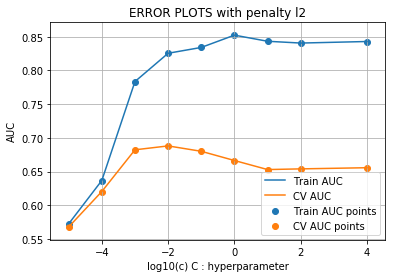

In [97]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import math

c_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000]
train_auc = []
cv_auc = []
log_c = []

#Since we dont have any perdict_proba method in the linearSVC, we're using CalibratedClassifierCV from the probabilities
#For further ref https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
for c in tqdm(c_values):
    l_svm = LinearSVC(C=c,loss='hinge',penalty='l2')
#CalibratedClassifierCV : http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
    ccc = CalibratedClassifierCV(l_svm) #ccc = CalibratedClassifierCV
    ccc.fit(X_tr, y_train)

    y_train_pred = ccc.predict(X_tr)
    y_cv_pred = ccc.predict(X_cr) 
    
    y_train_pred = ccc.predict_proba(X_tr)[:,1]    
    y_cv_pred = ccc.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    log_c.append(math.log10(c))

plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')

plt.scatter(log_c, train_auc, label='Train AUC points')
plt.scatter(log_c, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log10(c) C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS with penalty l2")
plt.grid()
plt.show()











  0%|                                                                                            | 0/9 [00:00<?, ?it/s]









 11%|█████████▎                                                                          | 1/9 [00:01<00:09,  1.19s/it]









 22%|██████████████████▋                                                                 | 2/9 [00:02<00:09,  1.31s/it]









 33%|████████████████████████████                                                        | 3/9 [00:06<00:11,  1.95s/it]









 44%|█████████████████████████████████████▎                                              | 4/9 [00:19<00:26,  5.36s/it]









 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:29<01:38, 24.59s/it]









 67%|████████████████████████████████████████████████████████                            | 6/9 [03:32<02:42, 54.12s/it]









 78%|█████████████████████████████████████████████████████████████████▎                

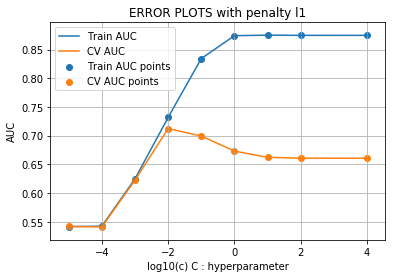

In [99]:
import warnings
warnings.filterwarnings('ignore')

c_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000]
train_auc = []
cv_auc = []
log_c = []


for c in tqdm(c_values):
    l_svm = LinearSVC(C=c,loss='l2',penalty='l1', dual=False)
    #For penalty we're taking loss as l2 and it throws error, so I have done as above. Ref : https://stackoverflow.com/a/34909049/10070614
    ccc = CalibratedClassifierCV(l_svm) #ccc = CalibratedClassifierCV
    ccc.fit(X_tr, y_train)

    y_train_pred = ccc.predict(X_tr)
    y_cv_pred = ccc.predict(X_cr) 
    
    y_train_pred = ccc.predict_proba(X_tr)[:,1]    
    y_cv_pred = ccc.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    log_c.append(math.log10(c))

plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')

plt.scatter(log_c, train_auc, label='Train AUC points')
plt.scatter(log_c, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log10(c) C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS with penalty l1")
plt.grid()
plt.show()

In [66]:
best_c = 0.01
best_penalty = 'l1'

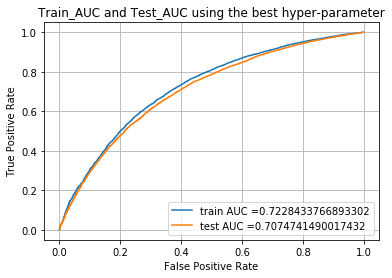

In [72]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve, auc

req_loss = ""
dual_ = True
if best_penalty == 'l1':
    req_loss = 'l2'
    dual_ = False
else:
    req_loss = 'l1'
    

l_svm = LinearSVC(C=best_c,loss=req_loss,penalty=best_penalty,dual=dual_)
ccc = CalibratedClassifierCV(l_svm)
ccc.fit(X_tr, y_train)

y_train_pred = ccc.predict_proba(X_tr)[:,1]    
y_test_pred = ccc.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

In [164]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.44734694829830307 for threshold 0.842


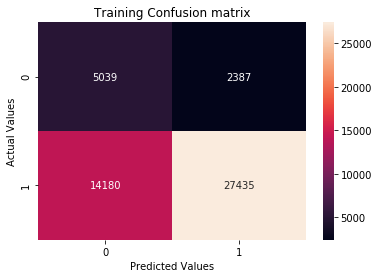

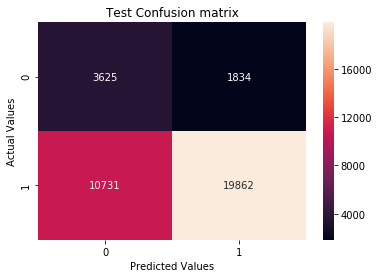

In [74]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [75]:
results = [['BOW',best_c,best_penalty,auc(train_fpr, train_tpr)]]
results


[['BOW', 0.01, 'l1', 0.7228433766893302]]

### 2.4.2 Set 2 TF-IDF

In [166]:
X_tr = hstack((X_train_essay_idf, X_train_title_idf,X_train_school_ohe, X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_project_grade_category_ohe , X_train_teacher_prefix_ohe, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((X_cv_essay_idf, X_cv_title_idf,X_cv_school_ohe, X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_project_grade_category_ohe , X_cv_teacher_prefix_ohe, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((X_test_essay_idf, X_test_title_idf,X_test_school_ohe, X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_project_grade_category_ohe , X_test_teacher_prefix_ohe, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 7076) (49041,)
(24155, 7076) (24155,)
(36052, 7076) (36052,)












  0%|                                                                                            | 0/9 [00:00<?, ?it/s]









 11%|█████████▎                                                                          | 1/9 [00:00<00:06,  1.25it/s]









 22%|██████████████████▋                                                                 | 2/9 [00:01<00:06,  1.12it/s]









 33%|████████████████████████████                                                        | 3/9 [00:04<00:07,  1.27s/it]









 44%|█████████████████████████████████████▎                                              | 4/9 [00:12<00:16,  3.34s/it]









 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:24<00:24,  6.03s/it]









 67%|████████████████████████████████████████████████████████                            | 6/9 [00:36<00:23,  7.93s/it]









 78%|█████████████████████████████████████████████████████████████████▎                

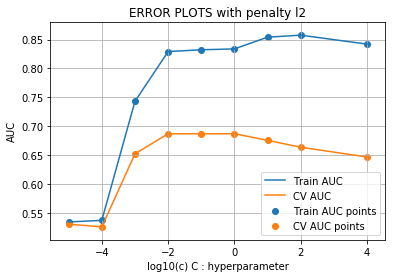

In [108]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import math

c_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000]
train_auc = []
cv_auc = []
log_c = []

#Since we dont have any perdict_proba method in the linearSVC, we're using CalibratedClassifierCV from the probabilities
#For further ref https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
for c in tqdm(c_values):
    l_svm = LinearSVC(C=c,loss='hinge',penalty='l2')
#CalibratedClassifierCV : http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
    ccc = CalibratedClassifierCV(l_svm) #ccc = CalibratedClassifierCV
    ccc.fit(X_tr, y_train)

    y_train_pred = ccc.predict(X_tr)
    y_cv_pred = ccc.predict(X_cr) 
    
    y_train_pred = ccc.predict_proba(X_tr)[:,1]    
    y_cv_pred = ccc.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    log_c.append(math.log10(c))

plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')

plt.scatter(log_c, train_auc, label='Train AUC points')
plt.scatter(log_c, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log10(c) C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS with penalty l2")
plt.grid()
plt.show()











  0%|                                                                                            | 0/9 [00:00<?, ?it/s]









 11%|█████████▎                                                                          | 1/9 [00:00<00:07,  1.07it/s]









 22%|██████████████████▋                                                                 | 2/9 [00:01<00:06,  1.04it/s]









 33%|████████████████████████████                                                        | 3/9 [00:03<00:05,  1.00it/s]









 44%|█████████████████████████████████████▎                                              | 4/9 [00:04<00:05,  1.20s/it]









 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:15<00:16,  4.06s/it]









 67%|████████████████████████████████████████████████████████                            | 6/9 [01:38<01:23, 27.80s/it]









 78%|█████████████████████████████████████████████████████████████████▎                

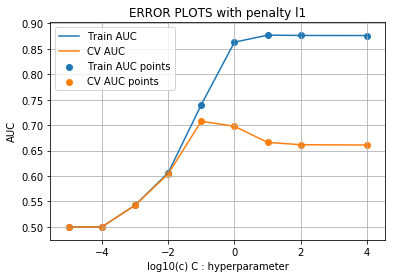

In [109]:
import warnings
warnings.filterwarnings('ignore')

c_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000]
train_auc = []
cv_auc = []
log_c = []


for c in tqdm(c_values):
    l_svm = LinearSVC(C=c,loss='l2',penalty='l1', dual=False)
    #For penalty we're taking loss as l2 and it throws error, so I have done as above. Ref : https://stackoverflow.com/a/34909049/10070614
    ccc = CalibratedClassifierCV(l_svm) #ccc = CalibratedClassifierCV
    ccc.fit(X_tr, y_train)

    y_train_pred = ccc.predict(X_tr)
    y_cv_pred = ccc.predict(X_cr) 
    
    y_train_pred = ccc.predict_proba(X_tr)[:,1]    
    y_cv_pred = ccc.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    log_c.append(math.log10(c))

plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')

plt.scatter(log_c, train_auc, label='Train AUC points')
plt.scatter(log_c, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log10(c) C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS with penalty l1")
plt.grid()
plt.show()

In [170]:
best_c = 0.1
best_penalty = 'l1' 

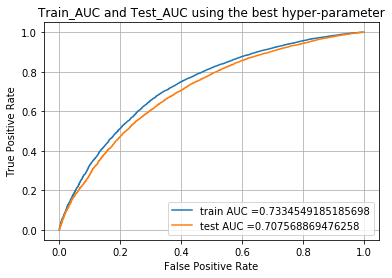

In [171]:
from sklearn.metrics import roc_curve, auc

req_loss = ""
dual_ = True
if best_penalty == 'l1':
    req_loss = 'l2'
    dual_ = False
else:
    req_loss = 'l1'
    

l_svm = LinearSVC(C=best_c,loss=req_loss,penalty=best_penalty,dual=dual_)
ccc = CalibratedClassifierCV(l_svm)
ccc.fit(X_tr, y_train)

y_train_pred = ccc.predict_proba(X_tr)[:,1]    
y_test_pred = ccc.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.46155206924671693 for threshold 0.844


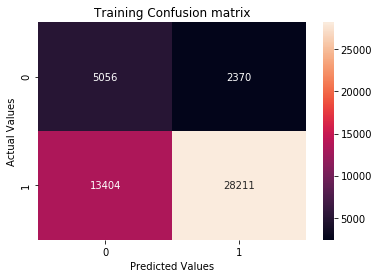

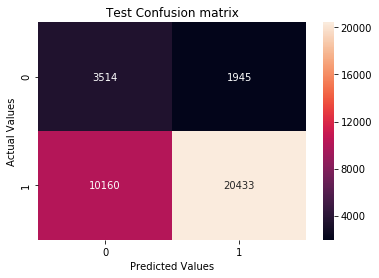

In [172]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [113]:
results_2 = [['TF-IDF',best_c,best_penalty,auc(train_fpr, train_tpr)]]
results_2


[['TF-IDF', 0.1, 'l1', 0.7400546815406341]]

### 2.4.3 Set 3 Average W2v

In [114]:
X_tr = hstack((avg_w2v_vectors_train, w2v_title_train,X_train_school_ohe, X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_project_grade_category_ohe , X_train_teacher_prefix_ohe, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((avg_w2v_vectors_cv, w2v_title_cv,X_cv_school_ohe, X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_project_grade_category_ohe , X_cv_teacher_prefix_ohe, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((avg_w2v_vectors_test, w2v_title_test,X_test_school_ohe, X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_project_grade_category_ohe , X_test_teacher_prefix_ohe, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 915) (49041,)
(24155, 915) (24155,)
(36052, 915) (36052,)












  0%|                                                                                            | 0/9 [00:00<?, ?it/s]









 11%|█████████▎                                                                          | 1/9 [00:03<00:29,  3.71s/it]









 22%|██████████████████▋                                                                 | 2/9 [00:07<00:25,  3.69s/it]









 33%|████████████████████████████                                                        | 3/9 [00:14<00:27,  4.62s/it]









 44%|█████████████████████████████████████▎                                              | 4/9 [02:38<03:53, 46.68s/it]









 56%|██████████████████████████████████████████████▋                                     | 5/9 [05:06<05:08, 77.04s/it]









 67%|███████████████████████████████████████████████████████▎                           | 6/9 [07:46<05:05, 101.85s/it]









 78%|████████████████████████████████████████████████████████████████▌                 

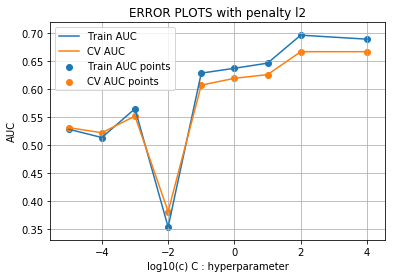

In [115]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import math

c_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000]
train_auc = []
cv_auc = []
log_c = []

#Since we dont have any perdict_proba method in the linearSVC, we're using CalibratedClassifierCV from the probabilities
#For further ref https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
for c in tqdm(c_values):
    l_svm = LinearSVC(C=c,loss='hinge',penalty='l2')
#CalibratedClassifierCV : http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
    ccc = CalibratedClassifierCV(l_svm) #ccc = CalibratedClassifierCV
    ccc.fit(X_tr, y_train)

    y_train_pred = ccc.predict(X_tr)
    y_cv_pred = ccc.predict(X_cr) 
    
    y_train_pred = ccc.predict_proba(X_tr)[:,1]    
    y_cv_pred = ccc.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    log_c.append(math.log10(c))

plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')

plt.scatter(log_c, train_auc, label='Train AUC points')
plt.scatter(log_c, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log10(c) C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS with penalty l2")
plt.grid()
plt.show()











  0%|                                                                                            | 0/9 [00:00<?, ?it/s]









 11%|█████████▎                                                                          | 1/9 [00:04<00:35,  4.48s/it]









 22%|██████████████████▋                                                                 | 2/9 [00:08<00:30,  4.42s/it]









 33%|████████████████████████████                                                        | 3/9 [00:15<00:29,  4.99s/it]









 44%|█████████████████████████████████████▎                                              | 4/9 [00:31<00:42,  8.41s/it]









 56%|██████████████████████████████████████████████▋                                     | 5/9 [02:25<02:40, 40.19s/it]









 67%|████████████████████████████████████████████████████████                            | 6/9 [06:23<04:58, 99.47s/it]









 78%|████████████████████████████████████████████████████████████████▌                 

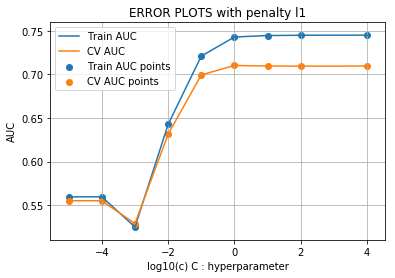

In [116]:
import warnings
warnings.filterwarnings('ignore')

c_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000]
train_auc = []
cv_auc = []
log_c = []


for c in tqdm(c_values):
    l_svm = LinearSVC(C=c,loss='l2',penalty='l1', dual=False)
    #For penalty we're taking loss as l2 and it throws error, so I have done as above. Ref : https://stackoverflow.com/a/34909049/10070614
    ccc = CalibratedClassifierCV(l_svm) #ccc = CalibratedClassifierCV
    ccc.fit(X_tr, y_train)

    y_train_pred = ccc.predict(X_tr)
    y_cv_pred = ccc.predict(X_cr) 
    
    y_train_pred = ccc.predict_proba(X_tr)[:,1]    
    y_cv_pred = ccc.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    log_c.append(math.log10(c))

plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')

plt.scatter(log_c, train_auc, label='Train AUC points')
plt.scatter(log_c, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log10(c) C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS with penalty l1")
plt.grid()
plt.show()

In [117]:
best_c = 0.1
best_penalty = 'l1'

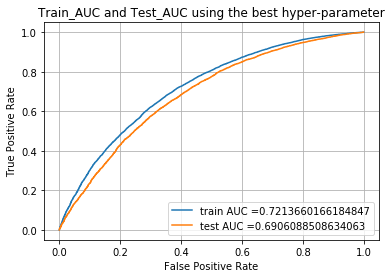

In [118]:
from sklearn.metrics import roc_curve, auc

req_loss = ""
dual_ = True
if best_penalty == 'l1':
    req_loss = 'l2'
    dual_ = False
else:
    req_loss = 'l1'
    

l_svm = LinearSVC(C=best_c,loss=req_loss,penalty=best_penalty,dual=dual_)
ccc = CalibratedClassifierCV(l_svm)
ccc.fit(X_tr, y_train)

y_train_pred = ccc.predict_proba(X_tr)[:,1]    
y_test_pred = ccc.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

In [119]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.44140578648253703 for threshold 0.839


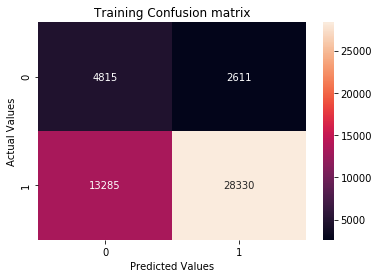

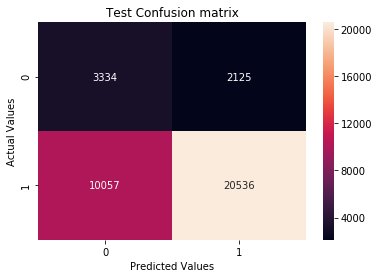

In [120]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [121]:
results_3 = [['AVG W2V',best_c,best_penalty,auc(train_fpr, train_tpr)]]
results_3


[['AVG W2V', 0.1, 'l1', 0.7213660166184847]]

### 2.4.4 Set 4 TFIDF weighted Average W2V

In [173]:
X_tr = hstack((tfidf_w2v_vectors_train, tfidf_w2v_title_train,X_train_school_ohe, X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_project_grade_category_ohe , X_train_teacher_prefix_ohe, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((tfidf_w2v_vectors_cv, tfidf_w2v_title_cv,X_cv_school_ohe, X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_project_grade_category_ohe , X_cv_teacher_prefix_ohe, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((tfidf_w2v_vectors_test, tfidf_w2v_title_test,X_test_school_ohe, X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_project_grade_category_ohe , X_test_teacher_prefix_ohe, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 701) (49041,)
(24155, 701) (24155,)
(36052, 701) (36052,)





  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


 11%|█████████▎                                                                          | 1/9 [00:03<00:27,  3.44s/it]


 22%|██████████████████▋                                                                 | 2/9 [00:06<00:23,  3.31s/it]


 33%|████████████████████████████                                                        | 3/9 [00:12<00:25,  4.17s/it]


 44%|█████████████████████████████████████▎                                              | 4/9 [02:32<03:44, 44.94s/it]


 56%|██████████████████████████████████████████████▋                                     | 5/9 [04:59<05:01, 75.38s/it]


 67%|████████████████████████████████████████████████████████                            | 6/9 [07:18<04:43, 94.45s/it]


 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [09:49<03:42, 111.41s/it]


 89%|████████████████

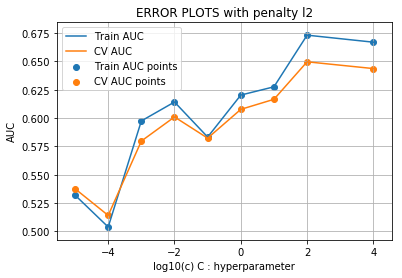

In [174]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import math

c_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000]
train_auc = []
cv_auc = []
log_c = []

#Since we dont have any perdict_proba method in the linearSVC, we're using CalibratedClassifierCV from the probabilities
#For further ref https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
for c in tqdm(c_values):
    l_svm = LinearSVC(C=c,loss='hinge',penalty='l2')
#CalibratedClassifierCV : http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
    ccc = CalibratedClassifierCV(l_svm) #ccc = CalibratedClassifierCV
    ccc.fit(X_tr, y_train)

    y_train_pred = ccc.predict(X_tr)
    y_cv_pred = ccc.predict(X_cr) 
    
    y_train_pred = ccc.predict_proba(X_tr)[:,1]    
    y_cv_pred = ccc.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    log_c.append(math.log10(c))

plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')

plt.scatter(log_c, train_auc, label='Train AUC points')
plt.scatter(log_c, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log10(c) C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS with penalty l2")
plt.grid()
plt.show()




  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


 11%|█████████▎                                                                          | 1/9 [00:03<00:31,  3.99s/it]


 22%|██████████████████▋                                                                 | 2/9 [00:07<00:27,  3.88s/it]


 33%|████████████████████████████                                                        | 3/9 [00:12<00:25,  4.19s/it]


 44%|█████████████████████████████████████▎                                              | 4/9 [00:29<00:40,  8.14s/it]


 56%|██████████████████████████████████████████████▋                                     | 5/9 [02:37<02:55, 43.89s/it]


 67%|████████████████████████████████████████████████████████                            | 6/9 [06:16<04:49, 96.60s/it]


 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [10:24<04:44, 142.04s/it]


 89%|████████████████

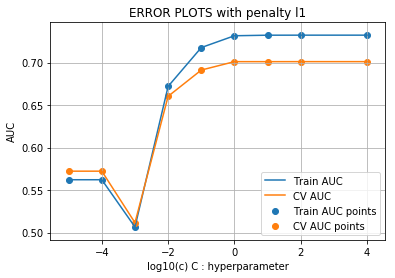

In [175]:
import warnings
warnings.filterwarnings('ignore')

c_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000]
train_auc = []
cv_auc = []
log_c = []


for c in tqdm(c_values):
    l_svm = LinearSVC(C=c,loss='l2',penalty='l1', dual=False)
    #For penalty we're taking loss as l2 and it throws error, so I have done as above. Ref : https://stackoverflow.com/a/34909049/10070614
    ccc = CalibratedClassifierCV(l_svm) #ccc = CalibratedClassifierCV
    ccc.fit(X_tr, y_train)

    y_train_pred = ccc.predict(X_tr)
    y_cv_pred = ccc.predict(X_cr) 
    
    y_train_pred = ccc.predict_proba(X_tr)[:,1]    
    y_cv_pred = ccc.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    log_c.append(math.log10(c))

plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')

plt.scatter(log_c, train_auc, label='Train AUC points')
plt.scatter(log_c, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log10(c) C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS with penalty l1")
plt.grid()
plt.show()

In [176]:
best_c = 1
best_penalty = 'l1'

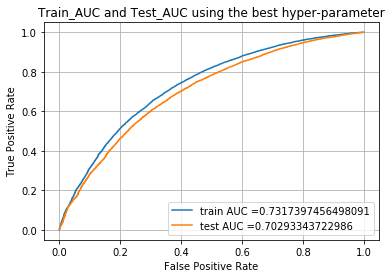

In [177]:
from sklearn.metrics import roc_curve, auc

req_loss = ""
dual_ = True
if best_penalty == 'l1':
    req_loss = 'l2'
    dual_ = False
else:
    req_loss = 'l1'
    

l_svm = LinearSVC(C=best_c,loss=req_loss,penalty=best_penalty,dual=dual_)
ccc = CalibratedClassifierCV(l_svm)
ccc.fit(X_tr, y_train)

y_train_pred = ccc.predict_proba(X_tr)[:,1]    
y_test_pred = ccc.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

In [178]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.45420921565687855 for threshold 0.834


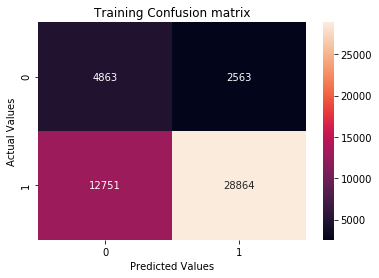

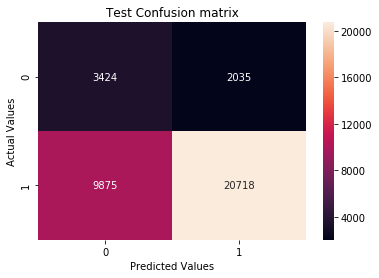

In [179]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [180]:
results_4 = [['TFIDF weighted W2V',best_c,best_penalty,auc(train_fpr, train_tpr)]]
results_4


[['TFIDF weighted W2V', 1, 'l1', 0.7317397456498091]]

### 2.4.5 Set 5 

In [76]:
vectorizer = TfidfVectorizer(min_df=10, max_features=5000 )
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_idf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_idf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_idf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_idf.shape, y_train.shape)
print(X_cv_essay_idf.shape, y_cv.shape)
print(X_test_essay_idf.shape, y_test.shape)
print("="*100)
essay_tfidf_features = vectorizer.get_feature_names()

After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:31<00:00, 37.13s/it]


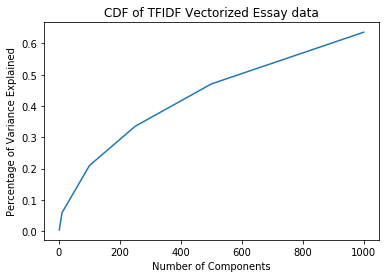

In [77]:
from sklearn.decomposition import TruncatedSVD

# Taking variance ratio in the TrucatedSVD https://stackoverflow.com/q/54411576/10070614
# Elbow method : https://en.wikipedia.org/wiki/Elbow_method_(clusterin

components = [1,10,100,250,500,1000]
variance = []

for c in tqdm(components):
    tsvd = TruncatedSVD(n_components = c)
    tsvd.fit(X_train_essay_idf)
    total = tsvd.explained_variance_ratio_.sum()
    variance.append(total)

plt.plot(components,variance)
plt.xlabel("Number of Components")
plt.ylabel("Percentage of Variance Explained")
plt.title("CDF of TFIDF Vectorized Essay data")
plt.show()

**IMPORTANT : I'm taking the best n_components as 1000 only with 65% variance preservance only as my system is hanging when I'm running for the components more than 1000. My laptop is i5 and 6GB of RAM**

In [79]:
best_component = 1000

In [80]:
tsvd = TruncatedSVD(n_components = best_component)
tsvd.fit(X_train_essay_idf)
X_train_essay_tsvd = tsvd.transform(X_train_essay_idf)
X_cv_essay_tsvd = tsvd.transform(X_cv_essay_idf)
X_test_essay_tsvd = tsvd.transform(X_test_essay_idf)

print("After vectorizations")
print(X_train_essay_tsvd.shape, y_train.shape)
print(X_cv_essay_tsvd.shape, y_cv.shape)
print(X_test_essay_tsvd.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1000) (49041,)
(24155, 1000) (24155,)
(36052, 1000) (36052,)


In [81]:
print(X_train_sentiment_norm.shape)
print(X_train_words_title_norm.shape)
print(X_train_words_essay_norm.shape)
print(X_train_quantity_norm.shape)

(1, 49041)
(1, 49041)
(1, 49041)
(1, 49041)


In [82]:
X_train_sentiment_norm = X_train_sentiment_norm.T
X_train_words_title_norm = X_train_words_title_norm.T
X_train_words_essay_norm = X_train_words_essay_norm.T
X_train_quantity_norm = X_train_quantity_norm.T

X_cv_sentiment_norm = X_cv_sentiment_norm.T
X_cv_words_title_norm = X_cv_words_title_norm.T
X_cv_words_essay_norm = X_cv_words_essay_norm.T
X_cv_quantity_norm = X_cv_quantity_norm.T

X_test_sentiment_norm = X_test_sentiment_norm.T
X_test_words_title_norm = X_test_words_title_norm.T
X_test_words_essay_norm = X_test_words_essay_norm.T
X_test_quantity_norm = X_test_quantity_norm.T

In [84]:
X_tr = hstack((X_train_essay_tsvd,X_train_sentiment_norm, X_train_words_title_norm,X_train_words_essay_norm,X_train_quantity_norm,X_train_school_ohe, X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_project_grade_category_ohe , X_train_teacher_prefix_ohe, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((X_cv_essay_tsvd,X_cv_sentiment_norm, X_cv_words_title_norm,X_cv_words_essay_norm,X_cv_quantity_norm,X_cv_school_ohe, X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_project_grade_category_ohe , X_cv_teacher_prefix_ohe, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((X_test_essay_tsvd,X_test_sentiment_norm, X_test_words_title_norm,X_test_words_essay_norm,X_test_quantity_norm,X_test_school_ohe, X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_project_grade_category_ohe , X_test_teacher_prefix_ohe, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 1105) (49041,)
(24155, 1105) (24155,)
(36052, 1105) (36052,)





  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


 11%|█████████▎                                                                          | 1/9 [00:05<00:43,  5.46s/it]


 22%|██████████████████▋                                                                 | 2/9 [00:10<00:37,  5.43s/it]


 33%|████████████████████████████                                                        | 3/9 [00:23<00:46,  7.67s/it]


 44%|█████████████████████████████████████▎                                              | 4/9 [01:13<01:41, 20.30s/it]


 56%|██████████████████████████████████████████████▋                                     | 5/9 [04:30<04:53, 73.35s/it]


 67%|███████████████████████████████████████████████████████▎                           | 6/9 [07:55<05:38, 112.93s/it]


 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [11:23<04:42, 141.41s/it]


 89%|████████████████

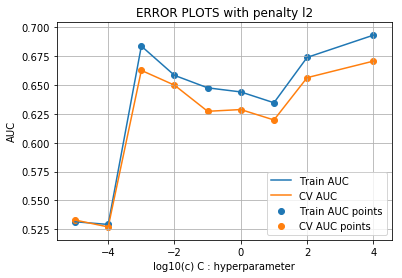

In [88]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc,roc_auc_score

c_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000]
train_auc = []
cv_auc = []
log_c = []

#Since we dont have any perdict_proba method in the linearSVC, we're using CalibratedClassifierCV from the probabilities
#For further ref https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
for c in tqdm(c_values):
    l_svm = LinearSVC(C=c,loss='hinge',penalty='l2')
#CalibratedClassifierCV : http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
    ccc = CalibratedClassifierCV(l_svm) #ccc = CalibratedClassifierCV
    ccc.fit(X_tr, y_train)

    y_train_pred = ccc.predict(X_tr)
    y_cv_pred = ccc.predict(X_cr) 
    
    y_train_pred = ccc.predict_proba(X_tr)[:,1]    
    y_cv_pred = ccc.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    log_c.append(math.log10(c))

plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')

plt.scatter(log_c, train_auc, label='Train AUC points')
plt.scatter(log_c, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log10(c) C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS with penalty l2")
plt.grid()
plt.show()




  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


 11%|█████████▎                                                                          | 1/9 [00:05<00:45,  5.70s/it]


 22%|██████████████████▋                                                                 | 2/9 [00:11<00:40,  5.76s/it]


 33%|████████████████████████████                                                        | 3/9 [00:17<00:35,  5.89s/it]


 44%|█████████████████████████████████████▎                                              | 4/9 [00:25<00:32,  6.56s/it]


 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:39<01:46, 26.66s/it]


 67%|███████████████████████████████████████████████████████▎                           | 6/9 [07:56<06:35, 131.79s/it]


 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [15:32<07:37, 228.93s/it]


 89%|████████████████

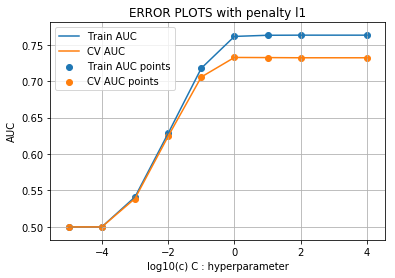

In [89]:
import warnings
warnings.filterwarnings('ignore')

c_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000]
train_auc = []
cv_auc = []
log_c = []


for c in tqdm(c_values):
    l_svm = LinearSVC(C=c,loss='l2',penalty='l1', dual=False)
    #For penalty we're taking loss as l2 and it throws error, so I have done as above. Ref : https://stackoverflow.com/a/34909049/10070614
    ccc = CalibratedClassifierCV(l_svm) #ccc = CalibratedClassifierCV
    ccc.fit(X_tr, y_train)

    y_train_pred = ccc.predict(X_tr)
    y_cv_pred = ccc.predict(X_cr) 
    
    y_train_pred = ccc.predict_proba(X_tr)[:,1]    
    y_cv_pred = ccc.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    log_c.append(math.log10(c))

plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')

plt.scatter(log_c, train_auc, label='Train AUC points')
plt.scatter(log_c, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log10(c) C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS with penalty l1")
plt.grid()
plt.show()

In [90]:
best_c = 1
best_penalty = 'l1'

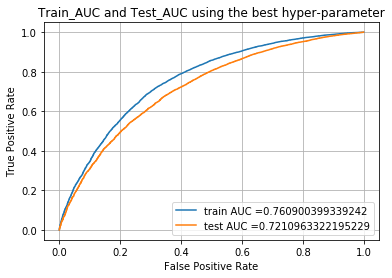

In [91]:
from sklearn.metrics import roc_curve, auc

req_loss = ""
dual_ = True
if best_penalty == 'l1':
    req_loss = 'l2'
    dual_ = False
else:
    req_loss = 'l1'
    

l_svm = LinearSVC(C=best_c,loss=req_loss,penalty=best_penalty,dual=dual_)
ccc = CalibratedClassifierCV(l_svm)
ccc.fit(X_tr, y_train)

y_train_pred = ccc.predict_proba(X_tr)[:,1]    
y_test_pred = ccc.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

In [92]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.4910701475593269 for threshold 0.835


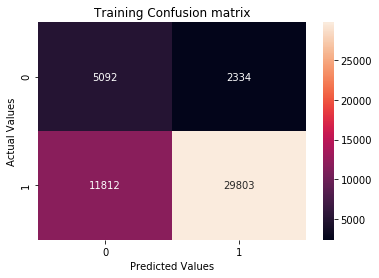

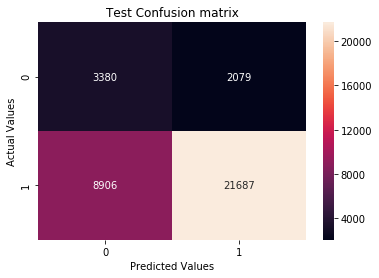

In [93]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [97]:
results_5 = [['Trucated SVD',best_c,best_penalty,auc(train_fpr, train_tpr)]]
results_5


[['Trucated SVD', 1, 'l1', 0.760900399339242]]

# 3 Conclusion

In [182]:
from tabulate import tabulate

final_results = results.copy()
final_results.append(results_2[0])
final_results.append(results_3[0])
final_results.append(results_4[0])
final_results.append(results_5[0])
final_results
print(tabulate(final_results, headers=['Vectorizer','C-value','Penalty','AUC'],tablefmt='orgtbl'))

| Vectorizer         |   C-value | Penalty   |      AUC |
|--------------------+-----------+-----------+----------|
| BOW                |      0.01 | l1        | 0.722843 |
| TF-IDF             |      0.1  | l1        | 0.740055 |
| AVG W2V            |      0.1  | l1        | 0.721366 |
| TFIDF weighted W2V |      1    | l1        | 0.73174  |
| Trucated SVD       |      1    | l1        | 0.7609   |
